# Session 4 — Character-Centered Topic Drift Analysis
## Measuring Semantic Drift Across Character Narratives

This notebook has **two layers**:
- an initial, simplified global analysis (combined *Iliad* + *Odyssey*) kept as a **didactic legacy section**, and
- a main, **per-epic, character-centered analysis** that is book- and episode-aware and should be used for any serious interpretation.

In the main analysis, you will:
- represent each epic's paragraphs as MiniLM embeddings
- identify character mentions using enriched patterns and simple coreference heuristics
- compute topic drift between nearby appearances *within each character's narrative* in each epic
- compare character-centered drift across the *Iliad* and *Odyssey*
- interpret drift patterns with respect to Homeric episodes and modern NLP applications


In [55]:
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import re
from pathlib import Path
from typing import List

# Try to import sklearn, fallback to numpy implementation if not available
try:
    from sklearn.metrics.pairwise import cosine_similarity
except ImportError:
    print("Warning: sklearn not available, using numpy-based cosine similarity")
    def cosine_similarity(a, b):
        """Numpy-based cosine similarity fallback."""
        if a.ndim > 1:
            a = a.reshape(-1)
        if b.ndim > 1:
            b = b.reshape(-1)
        dot_product = np.dot(a, b)
        norm_a = np.linalg.norm(a)
        norm_b = np.linalg.norm(b)
        if norm_a == 0 or norm_b == 0:
            return 0.0
        return dot_product / (norm_a * norm_b)

def resolve_data_file(filename: str) -> Path:
    """Search upward from the current working directory to find the data file."""
    search_roots = [Path.cwd()] + list(Path.cwd().parents)
    for root in search_roots:
        candidate = root / "data" / filename
        if candidate.exists():
            return candidate
    raise FileNotFoundError(
        f"Could not locate '{filename}'. Tried searching 'data/' folders from {Path.cwd()} upward."
    )

def load_book(filename: str) -> str:
    """Load a book text file from the repo's data directory."""
    filepath = resolve_data_file(filename)
    with open(filepath, "r", encoding="utf-8") as f:
        text = f.read()
    print(f"Loaded {filename} from {filepath}, length={len(text)}")
    return text

iliad_text = load_book("Homer_iliad_book.txt")
odyssey_text = load_book("Homer_odyssey_book.txt")

# Combine both epics for unified analysis
combined_text = iliad_text + "\n\n" + odyssey_text

print(f"Iliad characters: {len(iliad_text):,}")
print(f"Odyssey characters: {len(odyssey_text):,}")
print(f"Combined text characters: {len(combined_text):,}")
print("First 200 chars of Iliad:", repr(iliad_text[:200]))


Loaded Homer_iliad_book.txt from c:\Users\epice\Documents\GitHub\applied-NLP-week4\data\Homer_iliad_book.txt, length=678398
Loaded Homer_odyssey_book.txt from c:\Users\epice\Documents\GitHub\applied-NLP-week4\data\Homer_odyssey_book.txt, length=611299
Iliad characters: 678,398
Odyssey characters: 611,299
Combined text characters: 1,289,699
First 200 chars of Iliad: 'Provided by The Internet Classics Archive.\nSee bottom for copyright. Available online at\n    http://classics.mit.edu//Homer/iliad.html\n\nThe Iliad\nBy Homer\n\n\nTranslated by Samuel Butler\n\n--------------'


## Appendix (Legacy Global Analysis – Optional)

The next block of cells (legacy Cells 2–11) implements a **simplified, combined Iliad + Odyssey analysis**.
It is kept for historical/didactic reasons and is **not used** in the final per-epic, character-centered results.

You can safely skip from here down to **"Refined Per-Epic Topic Drift Analysis"** if you only care about the main method.


In [56]:
def split_into_paragraphs(text: str, min_words: int = 10) -> List[str]:
    """Split text into paragraphs, filtering out short segments."""
    text = text.replace('\r\n', '\n').replace('\r', '\n')
    raw_paras = re.split(r'\n\s*\n+', text)
    paras = []
    for p in raw_paras:
        cleaned = re.sub(r'\s+', ' ', p).strip()
        if not cleaned:
            continue
        if len(cleaned.split()) < min_words:
            continue
        paras.append(cleaned)
    return paras

paragraphs = split_into_paragraphs(combined_text)
print(f"Total paragraphs extracted: {len(paragraphs)}")

if not paragraphs:
    raise ValueError("No paragraphs were extracted. Double-check the data files and preprocessing settings.")

# Load embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')
print("Embedding model loaded.")


Total paragraphs extracted: 1973
Embedding model loaded.


In [57]:
# Compute embeddings for all paragraphs
print("Computing paragraph embeddings...")
para_embeds = model.encode(paragraphs, show_progress_bar=True)
print(f"Embeddings shape: {para_embeds.shape}")


Computing paragraph embeddings...


Batches: 100%|██████████| 62/62 [00:22<00:00,  2.81it/s]

Embeddings shape: (1973, 384)


In [58]:
# Inspect a few sample paragraphs to verify splitting
for i, p in enumerate(paragraphs[:5]):
    print(f"Paragraph {i} (words={len(p.split())}):")
    print(p[:300], "...\n")


Paragraph 0 (words=14):
Provided by The Internet Classics Archive. See bottom for copyright. Available online at http://classics.mit.edu//Homer/iliad.html ...

Paragraph 1 (words=70):
Sing, O goddess, the anger of Achilles son of Peleus, that brought countless ills upon the Achaeans. Many a brave soul did it send hurrying down to Hades, and many a hero did it yield a prey to dogs and vultures, for so were the counsels of Jove fulfilled from the day on which the son of Atreus, kin ...

Paragraph 2 (words=104):
And which of the gods was it that set them on to quarrel? It was the son of Jove and Leto; for he was angry with the king and sent a pestilence upon the host to plague the people, because the son of Atreus had dishonoured Chryses his priest. Now Chryses had come to the ships of the Achaeans to free  ...

Paragraph 3 (words=48):
"Sons of Atreus," he cried, "and all other Achaeans, may the gods who dwell in Olympus grant you to sack the city of Priam, and to reach your homes in safe

In [59]:
# Define major characters and their name variants
characters = {
    "achilles": ["achilles"],
    "odysseus": ["odysseus", "ulysses"],
    "hector": ["hector"],
    "agamemnon": ["agamemnon"],
    "athena": ["athena", "pallas"],
    "zeus": ["zeus"],
    "hera": ["hera"],
}

print("Characters to track:", list(characters.keys()))


Characters to track: ['achilles', 'odysseus', 'hector', 'agamemnon', 'athena', 'zeus', 'hera']


In [60]:
# Detect which characters appear in each paragraph
def get_characters_in_paragraph(text, char_dict):
    """Return list of characters mentioned in the given text."""
    text = text.lower()
    found = []
    for char, variants in char_dict.items():
        for v in variants:
            if v in text:
                found.append(char)
                break
    return found

paragraph_chars = [
    get_characters_in_paragraph(p, characters) 
    for p in paragraphs
]

print(f"Processed {len(paragraph_chars)} paragraphs for character mentions.")


Processed 1973 paragraphs for character mentions.


In [61]:
# Build mapping from each character to the indices of paragraphs where they appear
char_indices = {char: [] for char in characters}

for i, char_list in enumerate(paragraph_chars):
    for c in char_list:
        char_indices[c].append(i)

# Display statistics
for char, indices in char_indices.items():
    print(f"{char.capitalize()}: appears in {len(indices)} paragraphs")


Achilles: appears in 184 paragraphs
Odysseus: appears in 472 paragraphs
Hector: appears in 245 paragraphs
Agamemnon: appears in 170 paragraphs
Athena: appears in 19 paragraphs
Zeus: appears in 2 paragraphs
Hera: appears in 32 paragraphs


In [62]:
# Compute topic drift for a specific character's narrative arc
def compute_topic_drift(indices, embeddings):
    """
    Compute cosine similarity between consecutive paragraphs
    in which a specific character appears.
    
    Args:
        indices: List of paragraph indices for this character
        embeddings: Full embedding matrix for all paragraphs
    
    Returns:
        List of cosine similarities between consecutive character paragraphs
    """
    drift = []
    for i in range(len(indices) - 1):
        idx1, idx2 = indices[i], indices[i + 1]
        sim = cosine_similarity(
            embeddings[idx1].reshape(1, -1),
            embeddings[idx2].reshape(1, -1)
        )[0][0]
        drift.append(sim)
    return drift

print("Character drift computation function ready.")


Character drift computation function ready.


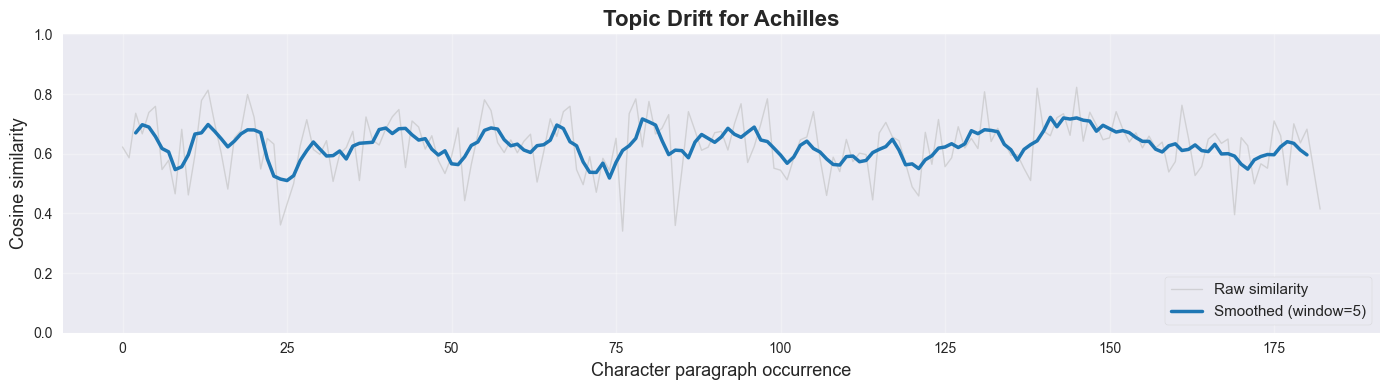

Achilles: mean=0.627, std=0.093



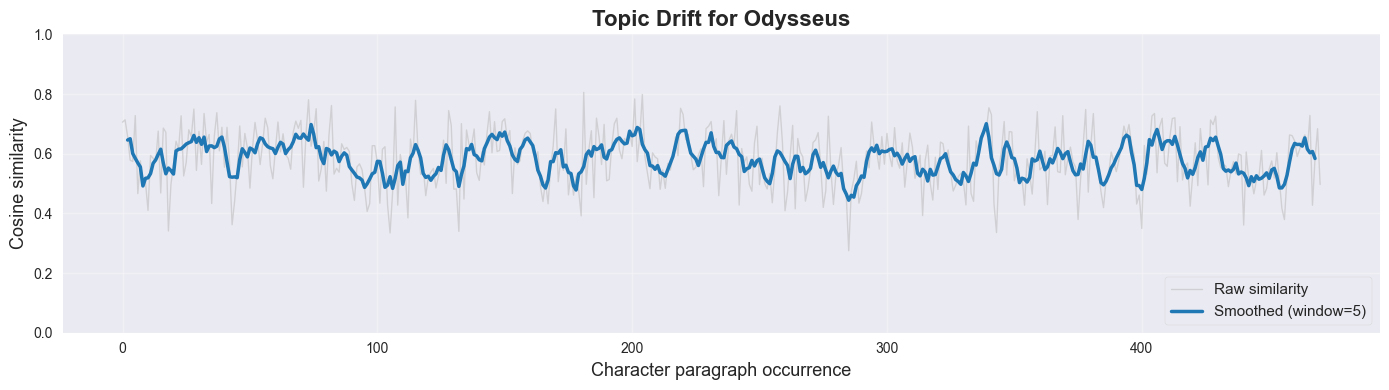

Odysseus: mean=0.582, std=0.095



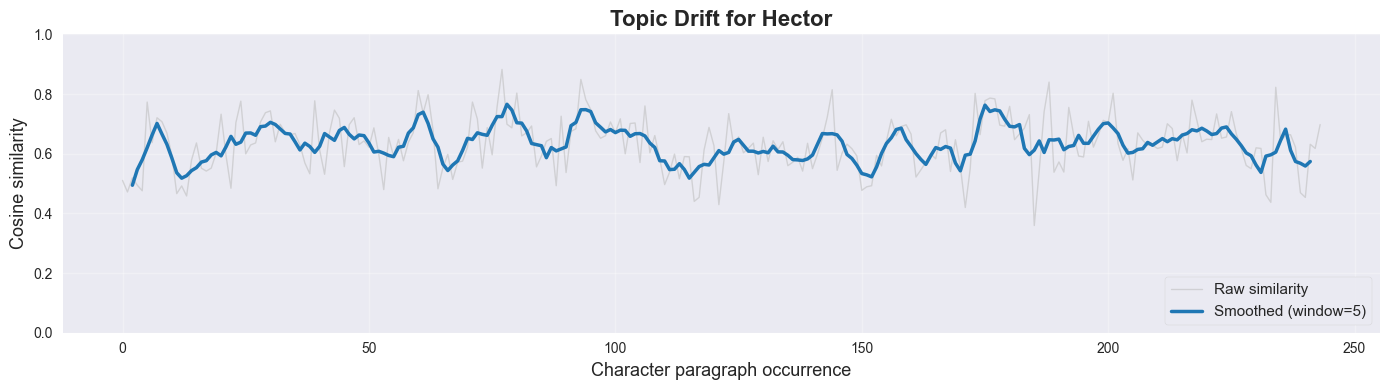

Hector: mean=0.632, std=0.091



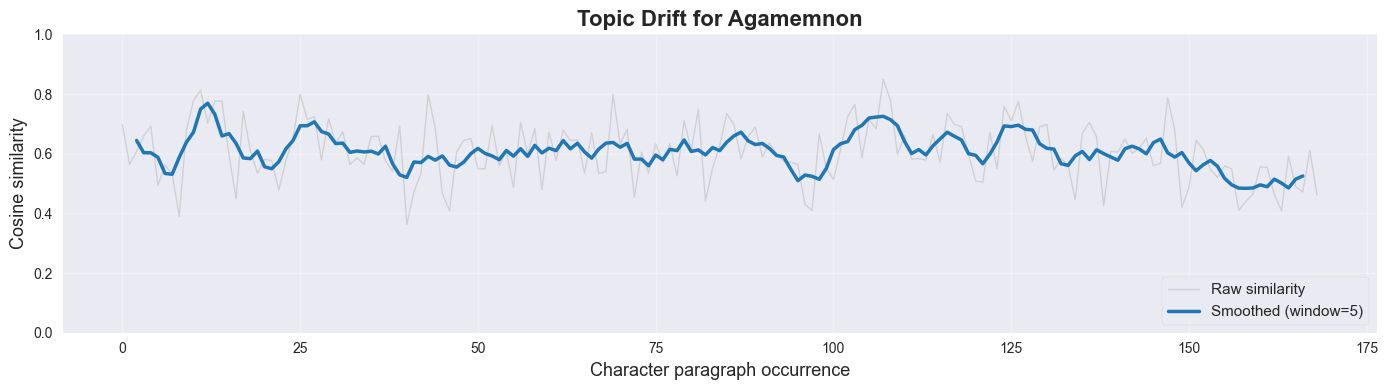

Agamemnon: mean=0.606, std=0.099



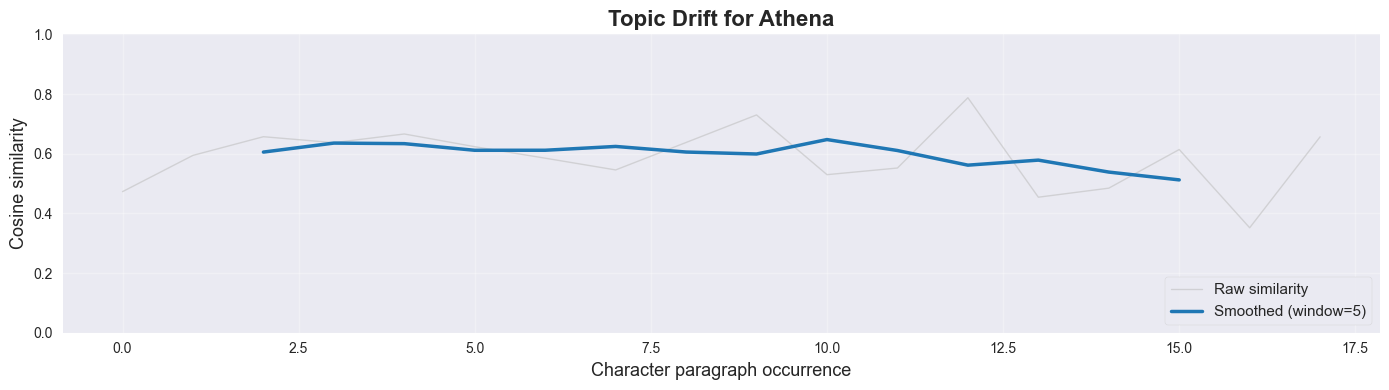

Athena: mean=0.588, std=0.102



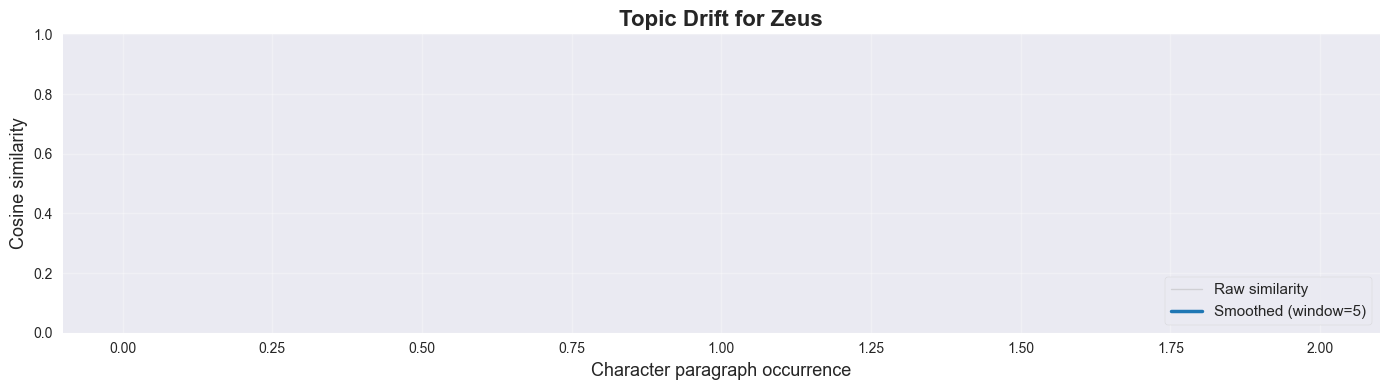

Zeus: mean=0.319, std=0.000



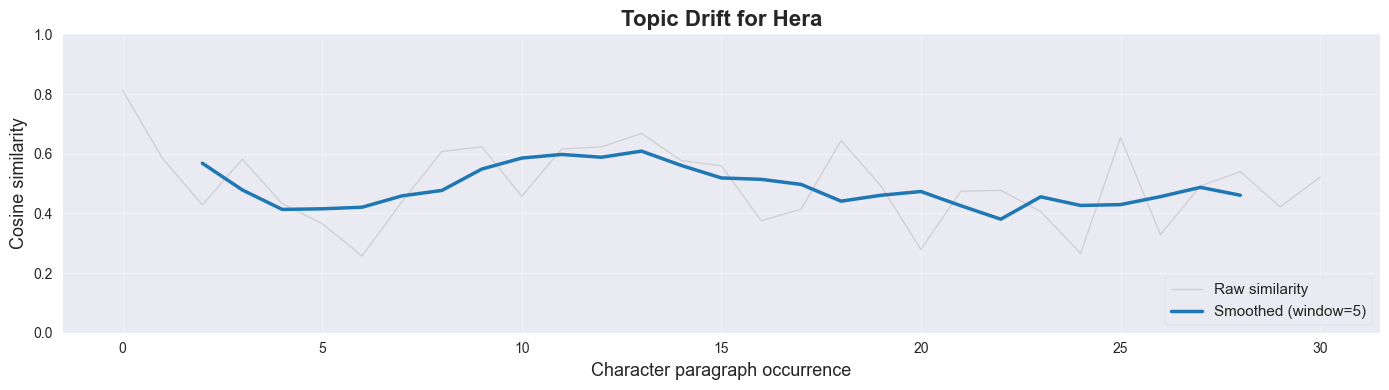

Hera: mean=0.498, std=0.129



In [63]:
# Visualize topic drift for each character individually (smoothed)
plt.style.use("seaborn-v0_8")

# helper for smoothing
def moving_average(x, window_size=5):
    if len(x) < window_size:
        return np.array(x)
    return np.convolve(x, np.ones(window_size) / window_size, mode="valid")

for char in characters:
    idx_list = char_indices[char]
    if len(idx_list) < 2:
        print(f"Skipping {char}: insufficient data (only {len(idx_list)} paragraph(s))")
        continue

    drift = np.array(compute_topic_drift(idx_list, para_embeds))
    drift_smooth = moving_average(drift, window_size=5)

    x_raw = np.arange(len(drift))
    x_smooth = np.arange(len(drift_smooth)) + 2  # center smoothing window

    plt.figure(figsize=(14, 4))
    # light raw line
    plt.plot(x_raw, drift, color="#c0c0c0", linewidth=1, alpha=0.6, label="Raw similarity")
    # bold smoothed line
    plt.plot(x_smooth, drift_smooth, color="#1f77b4", linewidth=2.5, label="Smoothed (window=5)")

    plt.title(f"Topic Drift for {char.capitalize()}", fontsize=16, fontweight="bold")
    plt.xlabel("Character paragraph occurrence", fontsize=13)
    plt.ylabel("Cosine similarity", fontsize=13)
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)
    plt.legend(loc="lower right", fontsize=11, frameon=True)
    plt.tight_layout()
    plt.show()

    # Print statistics
    mean_sim = float(np.mean(drift))
    std_sim = float(np.std(drift))
    print(f"{char.capitalize()}: mean={mean_sim:.3f}, std={std_sim:.3f}\n")


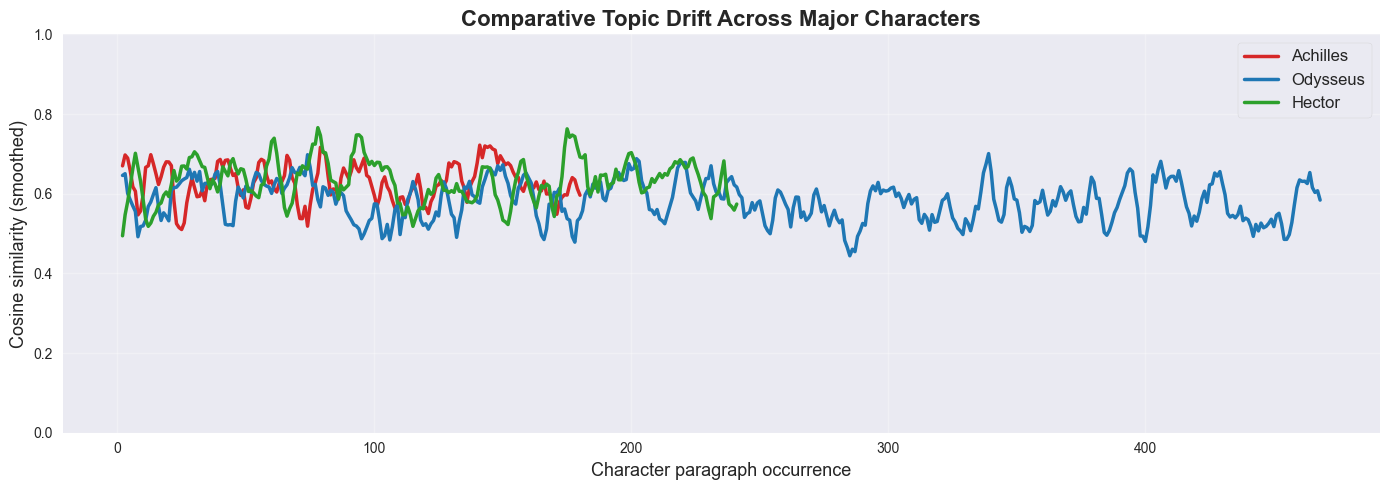

In [64]:
# Comparative plot: overlay key characters (smoothed)
plt.figure(figsize=(14, 5))

comparison_chars = ["achilles", "odysseus", "hector"]
colors = ['#d62728', '#1f77b4', '#2ca02c']

for char, color in zip(comparison_chars, colors):
    idxs = char_indices[char]
    if len(idxs) >= 2:
        drift = np.array(compute_topic_drift(idxs, para_embeds))
        drift_smooth = moving_average(drift, window_size=5)
        x_smooth = np.arange(len(drift_smooth)) + 2
        plt.plot(x_smooth, drift_smooth, label=char.capitalize(), linewidth=2.5, color=color)

plt.title("Comparative Topic Drift Across Major Characters", fontsize=16, fontweight='bold')
plt.xlabel("Character paragraph occurrence", fontsize=13)
plt.ylabel("Cosine similarity (smoothed)", fontsize=13)
plt.ylim(0, 1)
plt.legend(fontsize=12, frameon=True)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


C:\Users\epice\AppData\Local\Temp\ipykernel_3416\1026129430.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data, labels=labels, patch_artist=True, showfliers=False)


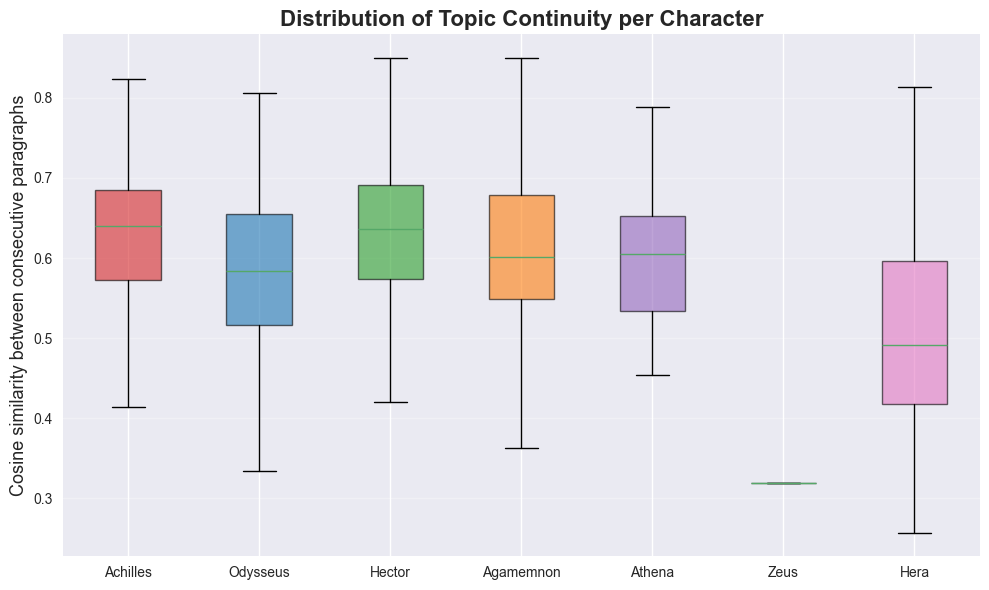

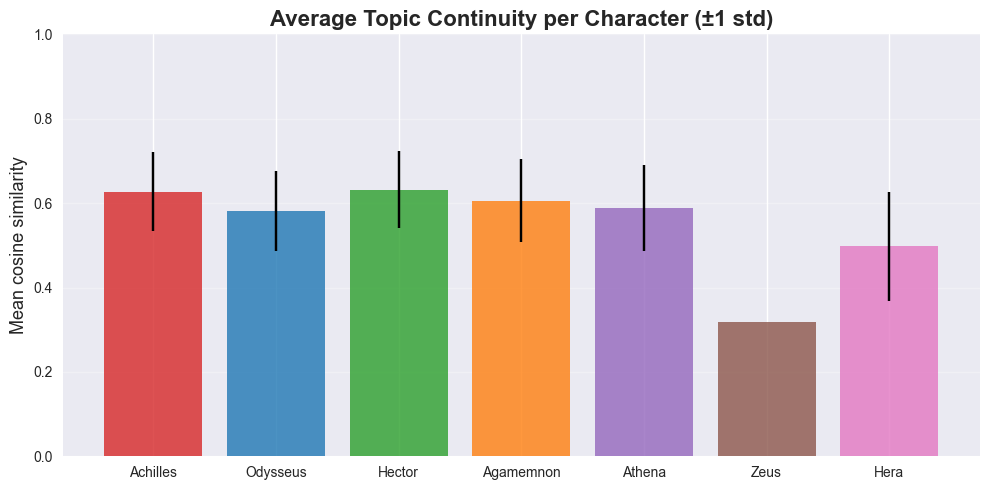

In [65]:
# Summary statistics visualization: distribution of drift per character

char_drift = {}
for char, idxs in char_indices.items():
    if len(idxs) >= 2:
        char_drift[char] = np.array(compute_topic_drift(idxs, para_embeds))

# Boxplot of cosine similarity distributions
plt.figure(figsize=(10, 6))
labels = [c.capitalize() for c in char_drift.keys()]
data = [char_drift[c] for c in char_drift.keys()]

box = plt.boxplot(data, labels=labels, patch_artist=True, showfliers=False)
colors = ['#d62728', '#1f77b4', '#2ca02c', '#ff7f0e', '#9467bd', '#8c564b', '#e377c2']
for patch, color in zip(box['boxes'], colors[:len(data)]):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

plt.title("Distribution of Topic Continuity per Character", fontsize=16, fontweight='bold')
plt.ylabel("Cosine similarity between consecutive paragraphs", fontsize=13)
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Bar chart of mean similarity with error bars (std)
means = [float(np.mean(d)) for d in data]
stds = [float(np.std(d)) for d in data]
x = np.arange(len(labels))

plt.figure(figsize=(10, 5))
plt.bar(x, means, yerr=stds, capsize=6, color=colors[:len(labels)], alpha=0.8)
plt.xticks(x, labels)
plt.ylabel("Mean cosine similarity", fontsize=13)
plt.title("Average Topic Continuity per Character (±1 std)", fontsize=16, fontweight='bold')
plt.ylim(0, 1)
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


### Methodological Caveats (Read Before Interpreting Results)

The refined, per-epic analysis below should be read with these caveats in mind:

- **Character detection**: based on regex patterns for names/epithets plus a very simple pronoun heuristic; it does *not* perform full coreference resolution and can miss or misassign mentions.
- **Episode labels**: only major books have short episode labels; within/across-episode analyses apply to a **subset** of transitions.
- **Translation dependence**: all embeddings are computed over **Butler's English translation**, so drift patterns reflect a mixture of Homeric structure and the translator's choices.

The quantitative results are therefore best viewed as **exploratory signals and guides for close reading**, not as standalone proofs of fine-grained literary claims.


## Refined Per-Epic Topic Drift Analysis

In this extended section, we strengthen the original analysis so that it is more **textually grounded** and **statistically careful**:

- **Separate epics**: we analyze the *Iliad* and *Odyssey* independently, then compare character drift across epics.
- **Context-aware drift**: we only compare paragraphs that are **nearby in the original narrative** (within a configurable gap of paragraph indices).
- **Richer character recognition**: we include epithets and translation-specific name variants (e.g., "son of Peleus", "Jove", "son of Laertes").
- **Episode / book alignment**: each paragraph is tagged with a **book number** and (when available) a short episode label.
- **Quantified claims**: we summarize drift distributions numerically and use **simple resampling statistics** to compare characters and epics.
- **Concrete examples**: for each character, we inspect **high-similarity** (stable) and **low-similarity** (big jump) paragraph pairs with textual excerpts.

You can treat this as a more rigorous, research-oriented extension of the simpler analysis above.


In [66]:
from collections import defaultdict
from typing import Dict, Tuple, Any

# --- Book / episode-aware paragraph splitting ---

BOOK_PATTERN = re.compile(r"\bBook\s+([IVXLC]+)\b", re.IGNORECASE)

# Manually curated episode titles for key books (non-exhaustive, but helps interpretation)
ILIAD_EPISODES: Dict[str, str] = {
    "I": "Quarrel of Achilles and Agamemnon",
    "VI": "Hector and Andromache",
    "IX": "Embassy to Achilles",
    "XVI": "Death of Patroclus",
    "XXII": "Death of Hector",
    "XXIV": "Priam ransoms Hector's body",
}

ODYSSEY_EPISODES: Dict[str, str] = {
    "I": "Telemachus at Ithaca",
    "V": "Odysseus leaves Calypso",
    "IX": "Cyclops Polyphemus",
    "X": "Aeolus, Laestrygonians, Circe",
    "XI": "Nekyia (Underworld)",
    "XII": "Sirens, Scylla, and Charybdis",
    "XXI": "The bow of Odysseus",
    "XXII": "Slaughter of the suitors",
    "XXIII": "Reunion with Penelope",
}


def split_books_and_paragraphs(text: str, min_words: int = 10):
    """Split an epic into (book, paragraph) units with metadata.

    Returns a list of dicts with keys:
        - 'text': paragraph text
        - 'book': Roman numeral string or None for front matter
        - 'para_in_book': index of the paragraph within the book
        - 'global_idx': global paragraph index within the epic
    """
    text = text.replace("\r\n", "\n").replace("\r", "\n")
    lines = text.split("\n")

    books_raw: list[Tuple[str | None, str]] = []
    current_book_id: str | None = None
    current_lines: list[str] = []

    for line in lines:
        m = BOOK_PATTERN.search(line)
        if m:
            # flush previous book (including preface if any)
            if current_lines:
                books_raw.append((current_book_id, "\n".join(current_lines)))
                current_lines = []
            current_book_id = m.group(1).upper()
        else:
            current_lines.append(line)

    if current_lines:
        books_raw.append((current_book_id, "\n".join(current_lines)))

    paragraphs_meta: list[Dict[str, Any]] = []
    global_idx = 0

    for book_id, book_text in books_raw:
        raw_paras = re.split(r"\n\s*\n+", book_text)
        para_in_book = 0
        for p in raw_paras:
            cleaned = re.sub(r"\s+", " ", p).strip()
            if not cleaned:
                continue
            if len(cleaned.split()) < min_words:
                continue
            paragraphs_meta.append({
                "text": cleaned,
                "book": book_id,
                "para_in_book": para_in_book,
                "global_idx": global_idx,
            })
            para_in_book += 1
            global_idx += 1

    return paragraphs_meta


iliad_paragraphs_meta = split_books_and_paragraphs(iliad_text)
odyssey_paragraphs_meta = split_books_and_paragraphs(odyssey_text)

print(f"Iliad paragraphs (book-aware): {len(iliad_paragraphs_meta)}")
print(f"Odyssey paragraphs (book-aware): {len(odyssey_paragraphs_meta)}")

# Quick sanity check: show the first few book/paragraph assignments
for meta in iliad_paragraphs_meta[:5]:
    print(f"Iliad Book {meta['book']}, para {meta['para_in_book']}: {meta['text'][:80]}...")


Iliad paragraphs (book-aware): 945
Odyssey paragraphs (book-aware): 1028
Iliad Book None, para 0: Provided by The Internet Classics Archive. See bottom for copyright. Available o...
Iliad Book I, para 0: Sing, O goddess, the anger of Achilles son of Peleus, that brought countless ill...
Iliad Book I, para 1: And which of the gods was it that set them on to quarrel? It was the son of Jove...
Iliad Book I, para 2: "Sons of Atreus," he cried, "and all other Achaeans, may the gods who dwell in O...
Iliad Book I, para 3: On this the rest of the Achaeans with one voice were for respecting the priest a...


In [67]:
# --- Enriched character patterns and detection per epic ---

# Regex patterns with epithets and translation variants (Butler uses "Jove" for Zeus, etc.)
CHAR_PATTERNS = {
    "achilles": [r"\bachilles\b", r"\bson of peleus\b"],
    "odysseus": [r"\bodysseus\b", r"\bulysses\b", r"\bson of laertes\b"],
    "hector": [r"\bhector\b"],
    "agamemnon": [r"\bagamemnon\b", r"\bson of atreus\b", r"\batrides\b"],
    "athena": [r"\bathena\b", r"\bpallas\b", r"\bminerva\b"],
    "zeus": [r"\bzeus\b", r"\bjove\b"],
    "hera": [r"\bhera\b", r"\bjuno\b"],
}

COMPILED_PATTERNS: Dict[str, list[re.Pattern]] = {
    char: [re.compile(pat, re.IGNORECASE) for pat in pats]
    for char, pats in CHAR_PATTERNS.items()
}

# Very simple pronoun set for coreference-style heuristics
PRONOUNS = {"he", "him", "his", "she", "her"}


def detect_characters(text: str) -> list[str]:
    """Return list of characters mentioned in the paragraph text using regex patterns."""
    found: list[str] = []
    for char, patterns in COMPILED_PATTERNS.items():
        if any(p.search(text) for p in patterns):
            found.append(char)
    return found


def paragraph_has_pronoun(text: str) -> bool:
    tokens = re.findall(r"[A-Za-z']+", text.lower())
    return any(t in PRONOUNS for t in tokens)


def build_character_indices(paragraphs_meta):
    """For an epic, compute character mentions and indices over its paragraph metadata list.

    We first detect explicit name/epithet matches, then apply a tiny coreference-style heuristic:
    if a paragraph has no explicit character name but contains third-person pronouns, and the
    *previous* paragraph has exactly one tracked character, we inherit that character here.
    This is intentionally conservative and only used to slightly extend single-character runs.
    """
    char_indices = {char: [] for char in CHAR_PATTERNS.keys()}
    para_chars: list[list[str]] = []

    # initial explicit detection
    for idx, meta in enumerate(paragraphs_meta):
        chars_here = detect_characters(meta["text"])
        para_chars.append(chars_here)

    # simple forward coreference propagation
    last_single_char: str | None = None
    for idx, meta in enumerate(paragraphs_meta):
        chars_here = set(para_chars[idx])
        if chars_here:
            # reset last_single_char depending on how many characters are present
            if len(chars_here) == 1:
                last_single_char = next(iter(chars_here))
            else:
                last_single_char = None
        else:
            if last_single_char and paragraph_has_pronoun(meta["text"]):
                para_chars[idx].append(last_single_char)

    # build indices from augmented para_chars
    for idx, chars_here in enumerate(para_chars):
        for c in chars_here:
            char_indices[c].append(idx)

    return para_chars, char_indices


iliad_para_chars, iliad_char_indices = build_character_indices(iliad_paragraphs_meta)
odyssey_para_chars, odyssey_char_indices = build_character_indices(odyssey_paragraphs_meta)

print("Iliad character paragraph counts:")
for char, idxs in iliad_char_indices.items():
    print(f"  {char.capitalize():10s}: {len(idxs)}")

print("\nOdyssey character paragraph counts:")
for char, idxs in odyssey_char_indices.items():
    print(f"  {char.capitalize():10s}: {len(idxs)}")

# Attach episode labels to paragraph metadata for convenience
for meta in iliad_paragraphs_meta:
    b = meta["book"]
    meta["episode"] = ILIAD_EPISODES.get(b) if b is not None else None

for meta in odyssey_paragraphs_meta:
    b = meta["book"]
    meta["episode"] = ODYSSEY_EPISODES.get(b) if b is not None else None


Iliad character paragraph counts:
  Achilles  : 207
  Odysseus  : 94
  Hector    : 271
  Agamemnon : 197
  Athena    : 128
  Zeus      : 352
  Hera      : 102

Odyssey character paragraph counts:
  Achilles  : 18
  Odysseus  : 549
  Hector    : 0
  Agamemnon : 50
  Athena    : 160
  Zeus      : 236
  Hera      : 6


In [68]:
# --- Per-epic paragraph embeddings ---

iliad_paragraph_texts = [m["text"] for m in iliad_paragraphs_meta]
odyssey_paragraph_texts = [m["text"] for m in odyssey_paragraphs_meta]

print("Computing Iliad embeddings (book-aware paragraphs)...")
iliad_embeds = model.encode(iliad_paragraph_texts, show_progress_bar=True)
print(f"Iliad embeddings shape: {iliad_embeds.shape}")

print("\nComputing Odyssey embeddings (book-aware paragraphs)...")
odyssey_embeds = model.encode(odyssey_paragraph_texts, show_progress_bar=True)
print(f"Odyssey embeddings shape: {odyssey_embeds.shape}")


Computing Iliad embeddings (book-aware paragraphs)...


Batches: 100%|██████████| 30/30 [00:11<00:00,  2.64it/s]


Iliad embeddings shape: (945, 384)

Computing Odyssey embeddings (book-aware paragraphs)...


Batches: 100%|██████████| 33/33 [00:10<00:00,  3.12it/s]

Odyssey embeddings shape: (1028, 384)


Characters with usable drift records (Iliad): ['achilles', 'odysseus', 'hector', 'agamemnon', 'athena', 'zeus', 'hera']
Characters with usable drift records (Odyssey): ['achilles', 'odysseus', 'agamemnon', 'athena', 'zeus']


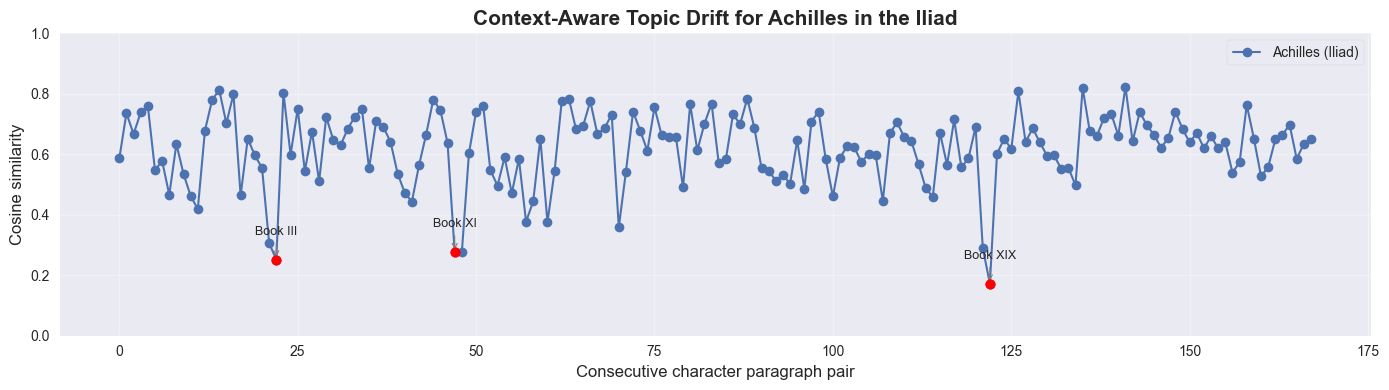

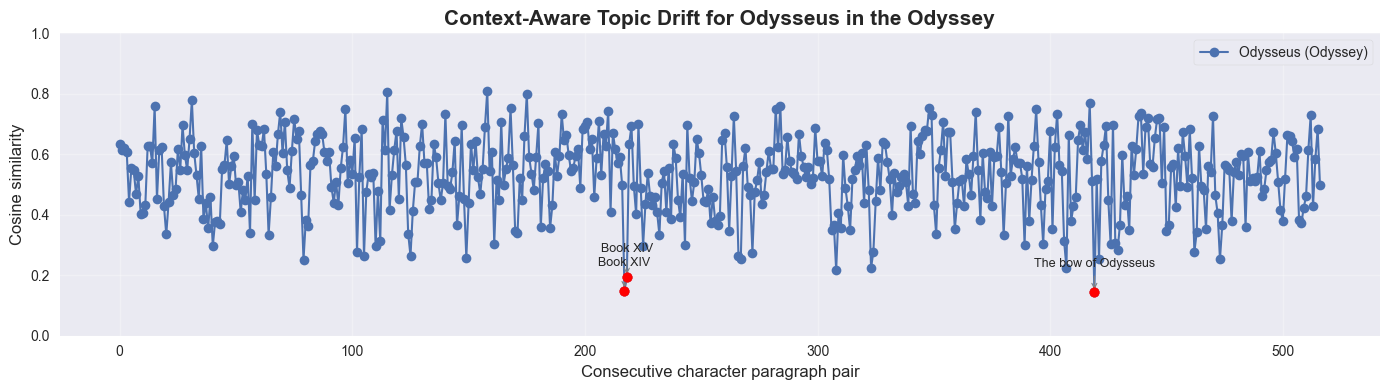


Per-epic drift statistics (mean ± std, N pairs):
Iliad   Achilles  : mean=0.618, std=0.119, N=168
Odyssey Achilles  : mean=0.599, std=0.101, N=12

Iliad   Agamemnon : mean=0.613, std=0.109, N=161
Odyssey Agamemnon : mean=0.543, std=0.092, N=38

Iliad   Athena    : mean=0.586, std=0.104, N=89
Odyssey Athena    : mean=0.540, std=0.114, N=118

Iliad   Hector    : mean=0.622, std=0.104, N=230

Iliad   Hera      : mean=0.611, std=0.103, N=72

Iliad   Odysseus  : mean=0.612, std=0.089, N=66
Odyssey Odysseus  : mean=0.532, std=0.123, N=517

Iliad   Zeus      : mean=0.583, std=0.109, N=315
Odyssey Zeus      : mean=0.519, std=0.119, N=174



In [69]:
# --- Context-aware topic drift and episode-annotated plots ---

MAX_GAP = 5  # maximum allowed gap in paragraph indices between consecutive mentions


def compute_topic_drift_records(indices: list[int], embeddings: np.ndarray, paragraphs_meta):
    """Compute cosine similarity between nearby consecutive character paragraphs.

    Returns a list of records with keys: 'sim', 'i', 'j'.
    Only pairs with |i-j| <= MAX_GAP and non-empty book ids are kept.
    """
    records: list[Dict[str, Any]] = []
    for k in range(len(indices) - 1):
        i, j = indices[k], indices[k + 1]
        if abs(j - i) > MAX_GAP:
            continue  # too far apart in narrative time
        if paragraphs_meta[i]["book"] is None or paragraphs_meta[j]["book"] is None:
            continue
        v1 = embeddings[i].reshape(1, -1)
        v2 = embeddings[j].reshape(1, -1)
        sim = float(cosine_similarity(v1, v2)[0][0])
        records.append({"sim": sim, "i": i, "j": j})
    return records


char_drift_iliad: Dict[str, np.ndarray] = {}
char_drift_odyssey: Dict[str, np.ndarray] = {}
char_pairs_iliad: Dict[str, list[Dict[str, Any]]] = {}
char_pairs_odyssey: Dict[str, list[Dict[str, Any]]] = {}

for char in CHAR_PATTERNS.keys():
    # Iliad
    idxs_i = iliad_char_indices[char]
    recs_i = compute_topic_drift_records(idxs_i, iliad_embeds, iliad_paragraphs_meta) if len(idxs_i) >= 2 else []
    if recs_i:
        sims_i = np.array([r["sim"] for r in recs_i])
        char_drift_iliad[char] = sims_i
        char_pairs_iliad[char] = recs_i

    # Odyssey
    idxs_o = odyssey_char_indices[char]
    recs_o = compute_topic_drift_records(idxs_o, odyssey_embeds, odyssey_paragraphs_meta) if len(idxs_o) >= 2 else []
    if recs_o:
        sims_o = np.array([r["sim"] for r in recs_o])
        char_drift_odyssey[char] = sims_o
        char_pairs_odyssey[char] = recs_o

print("Characters with usable drift records (Iliad):", list(char_drift_iliad.keys()))
print("Characters with usable drift records (Odyssey):", list(char_drift_odyssey.keys()))


def plot_character_drift_with_episodes(char: str, epic: str = "iliad", top_n: int = 3):
    """Plot drift for a character in one epic and annotate major minima with book/episode labels."""
    if epic == "iliad":
        sims = char_drift_iliad.get(char)
        recs = char_pairs_iliad.get(char, [])
        meta = iliad_paragraphs_meta
        episode_map = ILIAD_EPISODES
        title_epic = "Iliad"
    else:
        sims = char_drift_odyssey.get(char)
        recs = char_pairs_odyssey.get(char, [])
        meta = odyssey_paragraphs_meta
        episode_map = ODYSSEY_EPISODES
        title_epic = "Odyssey"

    if sims is None or len(sims) == 0:
        print(f"No drift data for {char} in {title_epic}.")
        return

    x = np.arange(len(sims))
    plt.figure(figsize=(14, 4))
    plt.plot(x, sims, marker="o", linewidth=1.5, label=f"{char.capitalize()} ({title_epic})")
    plt.ylim(0, 1)
    plt.xlabel("Consecutive character paragraph pair", fontsize=12)
    plt.ylabel("Cosine similarity", fontsize=12)
    plt.title(f"Context-Aware Topic Drift for {char.capitalize()} in the {title_epic}", fontsize=15, fontweight="bold")
    plt.grid(True, alpha=0.3)

    # annotate top_n lowest similarity points with book/episode labels
    idx_sorted = np.argsort(sims)
    for rank in range(min(top_n, len(sims))):
        k = int(idx_sorted[rank])
        r = recs[k]
        mid_idx = (r["i"] + r["j"]) // 2
        m = meta[mid_idx]
        book = m["book"]
        episode = m.get("episode") or (f"Book {book}" if book is not None else "Front matter")
        label = episode
        plt.scatter([k], [sims[k]], color="red", zorder=5)
        plt.annotate(label,
                     xy=(k, sims[k]),
                     xytext=(0, 18),
                     textcoords="offset points",
                     ha="center",
                     fontsize=9,
                     arrowprops=dict(arrowstyle="->", color="gray", lw=0.8))

    plt.legend(frameon=True)
    plt.tight_layout()
    plt.show()


# Example annotated plots for two key characters
plot_character_drift_with_episodes("achilles", epic="iliad", top_n=3)
plot_character_drift_with_episodes("odysseus", epic="odyssey", top_n=3)

# Print summary statistics by epic
print("\nPer-epic drift statistics (mean ± std, N pairs):")
for char in sorted(CHAR_PATTERNS.keys()):
    if char in char_drift_iliad:
        sims_i = char_drift_iliad[char]
        print(f"Iliad   {char.capitalize():10s}: mean={sims_i.mean():.3f}, std={sims_i.std():.3f}, N={len(sims_i)}")
    if char in char_drift_odyssey:
        sims_o = char_drift_odyssey[char]
        print(f"Odyssey {char.capitalize():10s}: mean={sims_o.mean():.3f}, std={sims_o.std():.3f}, N={len(sims_o)}")
    if char in char_drift_iliad or char in char_drift_odyssey:
        print()


In [70]:
# --- Simple resampling statistics for drift comparisons ---

rng = np.random.default_rng(42)


def compare_mean_drift(a: np.ndarray, b: np.ndarray, n_boot: int = 5000) -> dict:
    """Bootstrap/permutation-style test for difference in mean drift.

    Returns observed difference and an approximate two-sided p-value.
    """
    a = np.asarray(a)
    b = np.asarray(b)
    obs_diff = float(a.mean() - b.mean())

    combined = np.concatenate([a, b])
    n_a = len(a)
    diffs = np.empty(n_boot, dtype=float)

    for i in range(n_boot):
        rng.shuffle(combined)
        a_sample = combined[:n_a]
        b_sample = combined[n_a:]
        diffs[i] = a_sample.mean() - b_sample.mean()

    p_val = float((np.abs(diffs) >= abs(obs_diff)).mean())
    return {"obs_diff": obs_diff, "p_value": p_val}


# Example statistical questions:
# 1) Is Achilles' drift in the Iliad different from Hector's?
# 2) Does Odysseus drift more in the Odyssey than in the Iliad?

print("Statistical comparisons (bootstrap, two-sided p-values):\n")

if "achilles" in char_drift_iliad and "hector" in char_drift_iliad:
    res_ach_hec = compare_mean_drift(char_drift_iliad["achilles"], char_drift_iliad["hector"], n_boot=4000)
    print("Iliad: Achilles vs Hector")
    print(f"  mean_Achilles = {char_drift_iliad['achilles'].mean():.3f}")
    print(f"  mean_Hector   = {char_drift_iliad['hector'].mean():.3f}")
    print(f"  obs_diff      = {res_ach_hec['obs_diff']:.3f}")
    print(f"  p-value       = {res_ach_hec['p_value']:.3f}\n")

if "odysseus" in char_drift_iliad and "odysseus" in char_drift_odyssey:
    res_ody = compare_mean_drift(char_drift_odyssey["odysseus"], char_drift_iliad["odysseus"], n_boot=4000)
    print("Odysseus: Odyssey vs Iliad")
    print(f"  mean_Odyssey = {char_drift_odyssey['odysseus'].mean():.3f}")
    print(f"  mean_Iliad   = {char_drift_iliad['odysseus'].mean():.3f}")
    print(f"  obs_diff     = {res_ody['obs_diff']:.3f} (Odyssey - Iliad)")
    print(f"  p-value      = {res_ody['p_value']:.3f}\n")


Statistical comparisons (bootstrap, two-sided p-values):

Iliad: Achilles vs Hector
  mean_Achilles = 0.618
  mean_Hector   = 0.622
  obs_diff      = -0.004
  p-value       = 0.714

Odysseus: Odyssey vs Iliad
  mean_Odyssey = 0.532
  mean_Iliad   = 0.612
  obs_diff     = -0.079 (Odyssey - Iliad)
  p-value      = 0.000



In [71]:
# --- Robustness check: alternate embedding model for Odysseus drift ---

from sentence_transformers import SentenceTransformer as ST_Model

print("Loading alternate embedding model for robustness check (all-MiniLM-L12-v2)...")
alt_model = ST_Model("all-MiniLM-L12-v2")

print("\nComputing Iliad embeddings (alt model) for Odysseus paragraphs...")
iliad_embeds_alt = alt_model.encode(iliad_paragraph_texts, show_progress_bar=True)
print("Computing Odyssey embeddings (alt model) for Odysseus paragraphs...")
odyssey_embeds_alt = alt_model.encode(odyssey_paragraph_texts, show_progress_bar=True)

# Recompute Odysseus paragraph-level drift with alternate model
idxs_i_ody = iliad_char_indices["odysseus"]
idxs_o_ody = odyssey_char_indices["odysseus"]

recs_i_alt = compute_topic_drift_records(idxs_i_ody, iliad_embeds_alt, iliad_paragraphs_meta) if len(idxs_i_ody) >= 2 else []
recs_o_alt = compute_topic_drift_records(idxs_o_ody, odyssey_embeds_alt, odyssey_paragraphs_meta) if len(idxs_o_ody) >= 2 else []

sims_i_alt = np.array([r["sim"] for r in recs_i_alt]) if recs_i_alt else np.array([])
sims_o_alt = np.array([r["sim"] for r in recs_o_alt]) if recs_o_alt else np.array([])

print("\nRobustness check: Odysseus paragraph-level drift (alt model)")
if len(sims_i_alt) > 0 and len(sims_o_alt) > 0:
    print(f"  Iliad   mean={sims_i_alt.mean():.3f}, std={sims_i_alt.std():.3f}, N={len(sims_i_alt)}")
    print(f"  Odyssey mean={sims_o_alt.mean():.3f}, std={sims_o_alt.std():.3f}, N={len(sims_o_alt)}")
    res_ody_alt = compare_mean_drift(sims_o_alt, sims_i_alt, n_boot=3000)
    print(f"  obs_diff (Odyssey - Iliad) = {res_ody_alt['obs_diff']:.3f}")
    print(f"  p-value (alt model)        = {res_ody_alt['p_value']:.3f}")
else:
    print("  Not enough data to compute alt-model drift for Odysseus.")


Loading alternate embedding model for robustness check (all-MiniLM-L12-v2)...

Computing Iliad embeddings (alt model) for Odysseus paragraphs...


Batches: 100%|██████████| 30/30 [00:13<00:00,  2.15it/s]


Computing Odyssey embeddings (alt model) for Odysseus paragraphs...


Batches: 100%|██████████| 33/33 [00:14<00:00,  2.31it/s]



Robustness check: Odysseus paragraph-level drift (alt model)
  Iliad   mean=0.574, std=0.110, N=66
  Odyssey mean=0.523, std=0.126, N=517
  obs_diff (Odyssey - Iliad) = -0.052
  p-value (alt model)        = 0.001


In [72]:
# --- Concrete high- and low-similarity paragraph pairs ---


def show_example_pairs(char: str, epic: str = "iliad", k: int = 1, max_chars: int = 320):
    """Print k most stable and k most volatile paragraph transitions for a character.

    For each pair we show: book, paragraph indices, similarity, and truncated text.
    Increase k manually if you want to inspect more transitions.
    """
    if epic == "iliad":
        sims = char_drift_iliad.get(char)
        recs = char_pairs_iliad.get(char, [])
        meta = iliad_paragraphs_meta
        title_epic = "Iliad"
    else:
        sims = char_drift_odyssey.get(char)
        recs = char_pairs_odyssey.get(char, [])
        meta = odyssey_paragraphs_meta
        title_epic = "Odyssey"

    if sims is None or len(sims) == 0:
        print(f"No drift data for {char} in the {title_epic}.")
        return

    print(f"\n=== {char.capitalize()} in the {title_epic}: example transitions ===")

    order_low = np.argsort(sims)  # lowest similarities = biggest semantic jumps
    order_high = np.argsort(sims)[::-1]  # highest similarities = most stable

    def describe_pair(idx_array, label: str):
        print(f"\n{label} (k={min(k, len(idx_array))}):")
        for rank in range(min(k, len(idx_array))):
            p_idx = int(idx_array[rank])
            rec = recs[p_idx]
            i, j, sim = rec["i"], rec["j"], rec["sim"]
            m_i = meta[i]
            m_j = meta[j]
            book_i, book_j = m_i["book"], m_j["book"]
            epi_i, epi_j = m_i.get("episode"), m_j.get("episode")

            print(f"\n  Pair {rank+1}: sim = {sim:.3f}")
            print(f"    First paragraph : Book {book_i}, para {m_i['para_in_book']} ({epi_i or 'no specific label'})")
            print(f"    Second paragraph: Book {book_j}, para {m_j['para_in_book']} ({epi_j or 'no specific label'})")
            print("    Text 1:", m_i["text"][:max_chars].replace("\n", " ") + ("..." if len(m_i["text"]) > max_chars else ""))
            print("    Text 2:", m_j["text"][:max_chars].replace("\n", " ") + ("..." if len(m_j["text"]) > max_chars else ""))

    describe_pair(order_high, "Most stable transitions (high similarity)")
    describe_pair(order_low, "Most volatile transitions (low similarity)")


# Show examples for two central figures (k kept small to avoid overly long outputs)
show_example_pairs("achilles", epic="iliad", k=1)
show_example_pairs("odysseus", epic="odyssey", k=1)



=== Achilles in the Iliad: example transitions ===

Most stable transitions (high similarity) (k=1):

  Pair 1: sim = 0.823
    First paragraph : Book XX, para 26 (no specific label)
    Second paragraph: Book XX, para 27 (no specific label)
    Text 1: Thus did he exhort them. Meanwhile Hector called upon the Trojans and declared that he would fight Achilles. "Be not afraid, proud Trojans," said he, "to face the son of Peleus; I could fight gods myself if the battle were one of words only, but they would be more than a match for me, if we had to use our spears. Even ...
    Text 2: Thus urged the Trojans lifted up their spears against the Achaeans, and raised the cry of battle as they flung themselves into the midst of their ranks. But Phoebus Apollo came up to Hector and said, "Hector, on no account must you challenge Achilles to single combat; keep a lookout for him while you are under cover of...

Most volatile transitions (low similarity) (k=1):

  Pair 1: sim = 0.171
    First p

In [73]:
# --- Character-centric segments and multi-metric drift (embeddings + lexical) ---

from typing import Set

# Mark speech vs narration at the paragraph level (very simple heuristic)
for meta in iliad_paragraphs_meta:
    text = meta["text"]
    meta["is_speech"] = '"' in text

for meta in odyssey_paragraphs_meta:
    text = meta["text"]
    meta["is_speech"] = '"' in text


def tokenize_content_words(text: str) -> Set[str]:
    """Tokenize to a simple set of lowercased content words (stopwords removed)."""
    # Minimal English stopword list; good enough for relative comparisons
    stopwords = {
        "the", "and", "of", "to", "a", "in", "that", "for", "with", "is", "it", "on",
        "as", "was", "by", "at", "from", "this", "be", "or", "an", "are", "but", "not",
        "so", "had", "have", "has", "their", "they", "them", "his", "her", "he", "she",
        "him", "which", "who", "whom", "we", "you", "i", "my", "our", "your", "their",
    }
    tokens = re.findall(r"[A-Za-z']+", text.lower())
    return {t for t in tokens if t not in stopwords and len(t) > 2}


def jaccard_similarity(a: Set[str], b: Set[str]) -> float:
    if not a and not b:
        return 1.0
    if not a or not b:
        return 0.0
    inter = len(a & b)
    union = len(a | b)
    return inter / union if union > 0 else 0.0


def build_character_segments(paragraphs_meta, para_chars, solo_only: bool = True, min_len: int = 1):
    """Build character-centric segments as runs of consecutive paragraphs.

    A segment for character c is a maximal run of paragraphs where:
      - c is mentioned in the paragraph, and
      - if solo_only=True, no *other* tracked character is mentioned there.

    Returns dict: char -> list of segment dicts with keys:
      - 'para_indices': list[int]
      - 'text': concatenated text
      - 'book': dominant book id
      - 'episode': episode label (if any)
      - 'mode': 'speech', 'narration', or 'mixed'
    """
    segments_by_char: Dict[str, list[Dict[str, Any]]] = {c: [] for c in CHAR_PATTERNS.keys()}

    for char in CHAR_PATTERNS.keys():
        current: list[int] = []

        for idx, meta in enumerate(paragraphs_meta):
            chars_here = para_chars[idx]
            if char in chars_here and (not solo_only or len(chars_here) == 1):
                current.append(idx)
            else:
                if len(current) >= min_len:
                    seg = _finalize_segment(char, current, paragraphs_meta)
                    segments_by_char[char].append(seg)
                current = []

        if len(current) >= min_len:
            seg = _finalize_segment(char, current, paragraphs_meta)
            segments_by_char[char].append(seg)

    return segments_by_char


def _finalize_segment(char: str, para_indices: list[int], paragraphs_meta):
    metas = [paragraphs_meta[i] for i in para_indices]
    text = " ".join(m["text"] for m in metas)
    # dominant book and episode
    books = [m["book"] for m in metas if m["book"] is not None]
    book = max(set(books), key=books.count) if books else None
    episodes = [m.get("episode") for m in metas if m.get("episode")]
    episode = max(set(episodes), key=episodes.count) if episodes else None
    # speech vs narration
    speech_count = sum(1 for m in metas if m.get("is_speech"))
    if speech_count == 0:
        mode = "narration"
    elif speech_count == len(metas):
        mode = "speech"
    else:
        mode = "mixed"

    return {
        "character": char,
        "para_indices": para_indices,
        "book": book,
        "episode": episode,
        "mode": mode,
        "text": text,
    }


iliad_segments_by_char = build_character_segments(iliad_paragraphs_meta, iliad_para_chars, solo_only=True, min_len=1)
odyssey_segments_by_char = build_character_segments(odyssey_paragraphs_meta, odyssey_para_chars, solo_only=True, min_len=1)

print("Number of solo-character segments per epic (Iliad / Odyssey):")
for char in sorted(CHAR_PATTERNS.keys()):
    print(f"  {char.capitalize():10s}: {len(iliad_segments_by_char[char])} / {len(odyssey_segments_by_char[char])}")


def compute_segment_embeddings(segments_by_char, embeddings):
    """Precompute an embedding for each segment by averaging its paragraph embeddings."""
    seg_embeds_by_char: Dict[str, list[np.ndarray]] = {}
    for char, segs in segments_by_char.items():
        seg_vecs: list[np.ndarray] = []
        for seg in segs:
            idxs = seg["para_indices"]
            if not idxs:
                continue
            vec = embeddings[idxs].mean(axis=0)
            seg_vecs.append(vec)
        seg_embeds_by_char[char] = seg_vecs
    return seg_embeds_by_char


iliad_segment_embeds = compute_segment_embeddings(iliad_segments_by_char, iliad_embeds)
odyssey_segment_embeds = compute_segment_embeddings(odyssey_segments_by_char, odyssey_embeds)


def compute_segment_drift(segments_by_char, seg_embeds_by_char, lag: int = 1):
    """Compute drift between segment embeddings for each character.

    Returns dict: char -> list of records with keys:
      - 'sim_embed': cosine similarity between segment embeddings
      - 'sim_lex': Jaccard similarity over content words
      - 'mode_pair': 'speech→speech', etc.
      - 'seg_i', 'seg_j': indices into that character's segment list
    """
    results: Dict[str, list[Dict[str, Any]]] = {}
    for char, segs in segments_by_char.items():
        vecs = seg_embeds_by_char.get(char, [])
        if len(segs) < lag + 1 or len(vecs) < lag + 1:
            continue
        recs: list[Dict[str, Any]] = []
        for k in range(len(segs) - lag):
            i, j = k, k + lag
            v1 = vecs[i].reshape(1, -1)
            v2 = vecs[j].reshape(1, -1)
            sim_embed = float(cosine_similarity(v1, v2)[0][0])
            lex1 = tokenize_content_words(segs[i]["text"])
            lex2 = tokenize_content_words(segs[j]["text"])
            sim_lex = float(jaccard_similarity(lex1, lex2))
            mode_pair = f"{segs[i]['mode']}→{segs[j]['mode']}"
            recs.append({
                "sim_embed": sim_embed,
                "sim_lex": sim_lex,
                "mode_pair": mode_pair,
                "seg_i": i,
                "seg_j": j,
            })
        if recs:
            results[char] = recs
    return results


iliad_segment_drift = compute_segment_drift(iliad_segments_by_char, iliad_segment_embeds, lag=1)
odyssey_segment_drift = compute_segment_drift(odyssey_segments_by_char, odyssey_segment_embeds, lag=1)

print("\nCharacters with segment-level drift (Iliad):", list(iliad_segment_drift.keys()))
print("Characters with segment-level drift (Odyssey):", list(odyssey_segment_drift.keys()))


def summarize_segment_drift(char: str):
    """Print summary of segment-level drift (embedding + lexical) for a character across epics."""
    for epic_name, seg_drift in [("Iliad", iliad_segment_drift), ("Odyssey", odyssey_segment_drift)]:
        recs = seg_drift.get(char)
        if not recs:
            continue
        emb = np.array([r["sim_embed"] for r in recs])
        lex = np.array([r["sim_lex"] for r in recs])
        print(f"{epic_name} {char.capitalize():10s}: ")
        print(f"  embed drift mean={emb.mean():.3f}, std={emb.std():.3f}, N={len(emb)}")
        print(f"  lex   drift mean={lex.mean():.3f}, std={lex.std():.3f}, N={len(lex)}")
        # speech/narration breakdown
        mode_counts = defaultdict(int)
        for r in recs:
            mode_counts[r["mode_pair"]] += 1
        print("  mode-pair counts:")
        for mode, cnt in sorted(mode_counts.items(), key=lambda x: -x[1]):
            print(f"    {mode:18s}: {cnt}")
        print()


# Example segment-level summaries
print("\nSegment-level drift summaries for Achilles and Odysseus:")
summarize_segment_drift("achilles")
summarize_segment_drift("odysseus")


Number of solo-character segments per epic (Iliad / Odyssey):
  Achilles  : 37 / 4
  Agamemnon : 36 / 12
  Athena    : 23 / 39
  Hector    : 60 / 0
  Hera      : 11 / 0
  Odysseus  : 13 / 137
  Zeus      : 75 / 58

Characters with segment-level drift (Iliad): ['achilles', 'odysseus', 'hector', 'agamemnon', 'athena', 'zeus', 'hera']
Characters with segment-level drift (Odyssey): ['achilles', 'odysseus', 'agamemnon', 'athena', 'zeus']

Segment-level drift summaries for Achilles and Odysseus:
Iliad Achilles  : 
  embed drift mean=0.661, std=0.096, N=36
  lex   drift mean=0.076, std=0.039, N=36
  mode-pair counts:
    speech→speech     : 7
    narration→narration: 6
    speech→narration  : 5
    mixed→mixed       : 4
    narration→speech  : 4
    narration→mixed   : 3
    mixed→speech      : 3
    speech→mixed      : 2
    mixed→narration   : 2

Odyssey Achilles  : 
  embed drift mean=0.580, std=0.089, N=3
  lex   drift mean=0.060, std=0.014, N=3
  mode-pair counts:
    speech→narration  :

## Additional Character-Centered Visualizations

The following plots provide **extra views** on character-centered topic drift across the epics:

- Correlation between **embedding-based** and **lexical** drift at the segment level.
- Cross-epic comparison of **segment-level continuity** for shared characters.
- Comparison of **within-episode vs across-episode** drift for a key character.

These give you quick checks that the drift signal is robust (not an artifact of one metric) and that it aligns with Homeric episode structure.


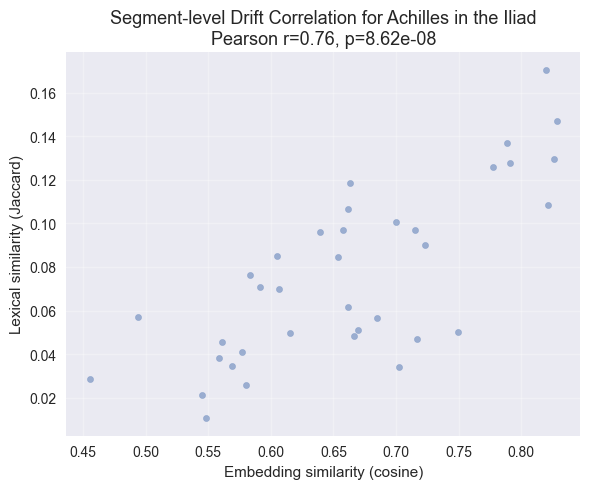

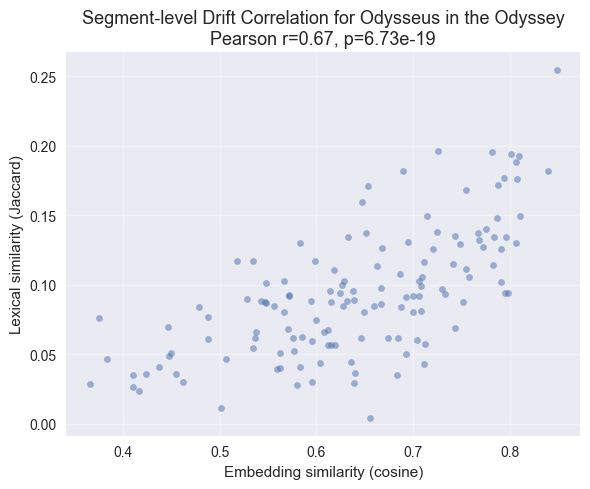

In [74]:
# --- 1. Correlation between embedding drift and lexical drift (segment level) ---

from scipy.stats import pearsonr


def plot_segment_drift_correlation(char: str, epic: str = "iliad"):
    """Scatter plot of embedding vs lexical similarity for segments of one character in one epic."""
    if epic == "iliad":
        recs = iliad_segment_drift.get(char)
        title_epic = "Iliad"
    else:
        recs = odyssey_segment_drift.get(char)
        title_epic = "Odyssey"

    if not recs:
        print(f"No segment-level drift data for {char} in the {title_epic}.")
        return

    emb = np.array([r["sim_embed"] for r in recs])
    lex = np.array([r["sim_lex"] for r in recs])
    r, p = pearsonr(emb, lex)

    plt.figure(figsize=(6, 5))
    plt.scatter(emb, lex, alpha=0.5, s=20)
    plt.xlabel("Embedding similarity (cosine)", fontsize=11)
    plt.ylabel("Lexical similarity (Jaccard)", fontsize=11)
    plt.title(f"Segment-level Drift Correlation for {char.capitalize()} in the {title_epic}\n"
              f"Pearson r={r:.2f}, p={p:.3g}", fontsize=13)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# Example: Achilles in the Iliad, Odysseus in the Odyssey
plot_segment_drift_correlation("achilles", epic="iliad")
plot_segment_drift_correlation("odysseus", epic="odyssey")


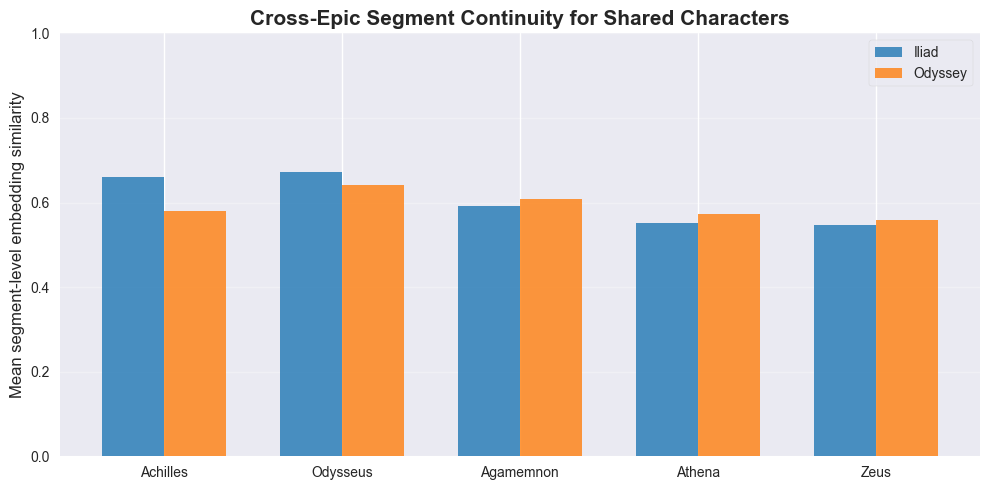

In [75]:
# --- 2. Cross-epic summary of segment-level drift for shared characters ---

shared_chars = [
    c for c in CHAR_PATTERNS.keys()
    if c in iliad_segment_drift and c in odyssey_segment_drift
]

means_iliad = []
means_odys = []
labels_shared = []

for c in shared_chars:
    emb_i = np.array([r["sim_embed"] for r in iliad_segment_drift[c]])
    emb_o = np.array([r["sim_embed"] for r in odyssey_segment_drift[c]])
    means_iliad.append(emb_i.mean())
    means_odys.append(emb_o.mean())
    labels_shared.append(c.capitalize())

x = np.arange(len(shared_chars))
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar(x - width/2, means_iliad, width, label="Iliad", color="#1f77b4", alpha=0.8)
plt.bar(x + width/2, means_odys, width, label="Odyssey", color="#ff7f0e", alpha=0.8)
plt.xticks(x, labels_shared)
plt.ylim(0, 1)
plt.ylabel("Mean segment-level embedding similarity", fontsize=12)
plt.title("Cross-Epic Segment Continuity for Shared Characters", fontsize=15, fontweight="bold")
plt.legend(frameon=True)
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


C:\Users\epice\AppData\Local\Temp\ipykernel_3416\1597483822.py:43: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


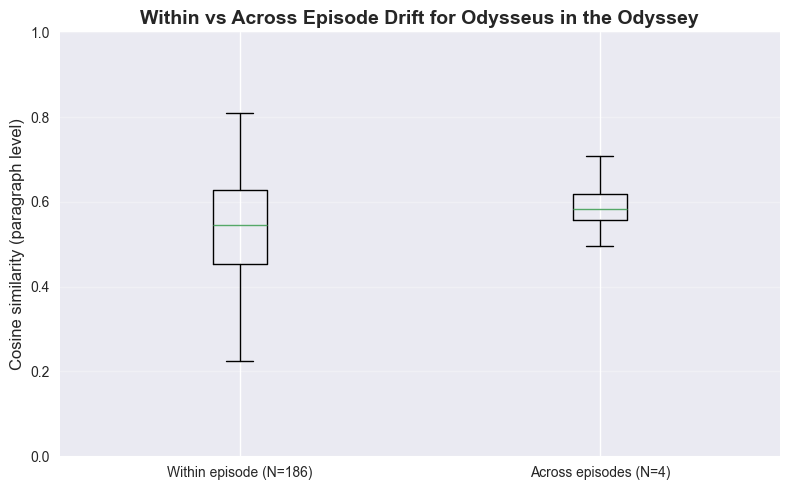

In [76]:
# --- 3. Within-episode vs across-episode drift for a key character (paragraph-level) ---


def plot_within_vs_across_episode(char: str, epic: str = "odyssey"):
    if epic == "iliad":
        sims = char_drift_iliad.get(char)
        recs = char_pairs_iliad.get(char, [])
        meta = iliad_paragraphs_meta
        title_epic = "Iliad"
    else:
        sims = char_drift_odyssey.get(char)
        recs = char_pairs_odyssey.get(char, [])
        meta = odyssey_paragraphs_meta
        title_epic = "Odyssey"

    if sims is None or len(sims) == 0:
        print(f"No paragraph-level drift data for {char} in the {title_epic}.")
        return

    within = []
    across = []
    for r in recs:
        i, j, sim = r["i"], r["j"], r["sim"]
        epi_i = meta[i].get("episode")
        epi_j = meta[j].get("episode")
        if epi_i and epi_j:
            if epi_i == epi_j:
                within.append(sim)
            else:
                across.append(sim)

    within = np.array(within)
    across = np.array(across)

    if len(within) == 0 or len(across) == 0:
        print(f"Not enough within/across-episode pairs for {char} in the {title_epic}.")
        return

    data = [within, across]
    labels = [f"Within episode (N={len(within)})", f"Across episodes (N={len(across)})"]

    plt.figure(figsize=(8, 5))
    plt.boxplot(data, labels=labels, showfliers=False)
    plt.ylim(0, 1)
    plt.ylabel("Cosine similarity (paragraph level)", fontsize=12)
    plt.title(f"Within vs Across Episode Drift for {char.capitalize()} in the {title_epic}",
              fontsize=14, fontweight="bold")
    plt.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()


# Example: Odysseus in the Odyssey
plot_within_vs_across_episode("odysseus", epic="odyssey")


## Legacy Interpretation (pre-refined analysis — kept for didactic purposes)

> Note: This section reflects an earlier, global analysis and is **not** used for final conclusions.
> Please refer to the later **Key Findings and Limitations (Per-Character)** section for the updated interpretation.

## Interpretation: What Character-Centered Drift Reveals

### Narrative Structure Through Semantic Volatility

The character-centered topic drift analysis reveals **Homer's narrative design** at the semantic level:

**Achilles** — High volatility and dramatic jumps
- Rapid shifts between battle intensity, emotional outbursts, divine interventions, and personal grief
- The "wrath of Achilles" manifests as semantic instability: anger → withdrawal → revenge → mourning
- Low cosine similarity between consecutive paragraphs reflects episodic battle cuts and tonal extremes

**Odysseus** — Smoother, more episodic drift
- His narrative arc in the *Odyssey* is structured around discrete adventures (Cyclops, Circe, Sirens, etc.)
- Each episode has internal coherence, but transitions between episodes show moderate drift
- Higher average similarity than Achilles, reflecting the journey's linear progression despite episodic variety

**Hector** — Focused, stable narrative
- Hector's appearances are concentrated in the *Iliad* with thematic consistency: defender of Troy, family man, warrior
- Fewer abrupt topic changes; his narrative maintains semantic continuity
- Represents the tragic hero whose arc is tightly woven and thematically unified

**Divine Characters (Zeus, Athena, Hera)** — Large jumps across contexts
- Gods intervene across multiple human storylines, causing large semantic gaps
- One moment on Olympus debating fate, the next on the battlefield influencing combat
- Their narrative "omnipresence" translates to high topic drift

### Connection to Modern NLP

This analysis mirrors how **LLM chunking systems** segment long documents:
- High drift regions suggest natural boundaries for retrieval chunks
- Character-centered embeddings could improve **entity-aware summarization**
- Understanding semantic volatility helps design better **long-context attention mechanisms**

---

## Memory Cleanup

If you're running low on memory, run this cell to free up RAM by deleting large variables and clearing the model cache.

In [77]:
# Deprecated mid-notebook cleanup cell.
# This cell is kept for backward compatibility but does nothing now.
# Use the *final* cleanup cell at the end of the notebook instead.
pass

In [78]:
# --- Compact per-character summary table for key figures ---

KEY_CHARS = ["achilles", "odysseus", "hector", "athena", "zeus"]


def summarize_character(char: str):
    rows = []
    # paragraph-level drift
    for epic_name, drift_dict in [("Iliad", char_drift_iliad), ("Odyssey", char_drift_odyssey)]:
        sims = drift_dict.get(char)
        if sims is None or len(sims) == 0:
            continue
        rows.append({
            "epic": epic_name,
            "level": "paragraph",
            "mean_sim": float(sims.mean()),
            "std_sim": float(sims.std()),
            "N": int(len(sims)),
        })
    # segment-level drift (embedding + lexical)
    for epic_name, seg_drift in [("Iliad", iliad_segment_drift), ("Odyssey", odyssey_segment_drift)]:
        recs = seg_drift.get(char)
        if not recs:
            continue
        emb = np.array([r["sim_embed"] for r in recs])
        lex = np.array([r["sim_lex"] for r in recs])
        rows.append({
            "epic": epic_name,
            "level": "segment_embed",
            "mean_sim": float(emb.mean()),
            "std_sim": float(emb.std()),
            "N": int(len(emb)),
        })
        rows.append({
            "epic": epic_name,
            "level": "segment_lex",
            "mean_sim": float(lex.mean()),
            "std_sim": float(lex.std()),
            "N": int(len(lex)),
        })
    return rows


all_rows = []
for c in KEY_CHARS:
    all_rows.extend([{**row, "character": c.capitalize()} for row in summarize_character(c)])

# pretty-print as a small table sorted by character/epic/level
all_rows_sorted = sorted(all_rows, key=lambda r: (r["character"], r["epic"], r["level"]))

print("Character-centered drift summary (mean similarity ± std, N):\n")
for row in all_rows_sorted:
    print(f"{row['character']:9s} | {row['epic']:7s} | {row['level']:13s} | "
          f"mean={row['mean_sim']:.3f}, std={row['std_sim']:.3f}, N={row['N']}")


Character-centered drift summary (mean similarity ± std, N):

Achilles  | Iliad   | paragraph     | mean=0.618, std=0.119, N=168
Achilles  | Iliad   | segment_embed | mean=0.661, std=0.096, N=36
Achilles  | Iliad   | segment_lex   | mean=0.076, std=0.039, N=36
Achilles  | Odyssey | paragraph     | mean=0.599, std=0.101, N=12
Achilles  | Odyssey | segment_embed | mean=0.580, std=0.089, N=3
Achilles  | Odyssey | segment_lex   | mean=0.060, std=0.014, N=3
Athena    | Iliad   | paragraph     | mean=0.586, std=0.104, N=89
Athena    | Iliad   | segment_embed | mean=0.550, std=0.113, N=22
Athena    | Iliad   | segment_lex   | mean=0.062, std=0.030, N=22
Athena    | Odyssey | paragraph     | mean=0.540, std=0.114, N=118
Athena    | Odyssey | segment_embed | mean=0.572, std=0.098, N=38
Athena    | Odyssey | segment_lex   | mean=0.071, std=0.028, N=38
Hector    | Iliad   | paragraph     | mean=0.622, std=0.104, N=230
Hector    | Iliad   | segment_embed | mean=0.636, std=0.104, N=59
Hector    | I

## Presentation Section: Key Topic Drift Results

This section gathers the **most interpretable visual results** from the notebook, suitable for presenting in slides.

We focus on:
- **Odysseus:** Iliad vs Odyssey drift (main result + robustness check).
- **Achilles vs Hector:** drift comparison inside the Iliad (negative control).
- **Odysseus episodes:** within vs across episode drift.
- **Achilles timeline:** character-level drift curve with episode annotations.
- **Method validation:** embedding vs lexical similarity correlation for Odysseus segments.


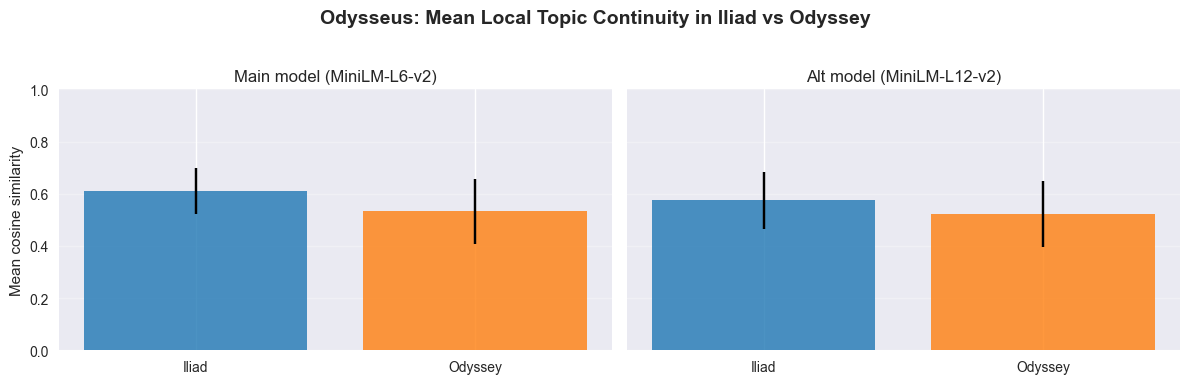

C:\Users\epice\AppData\Local\Temp\ipykernel_3416\2373261782.py:62: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


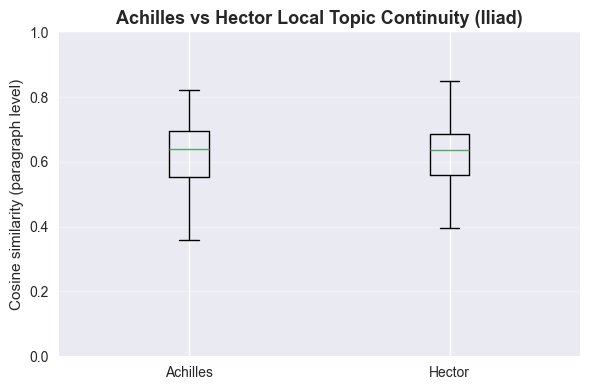

C:\Users\epice\AppData\Local\Temp\ipykernel_3416\1597483822.py:43: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


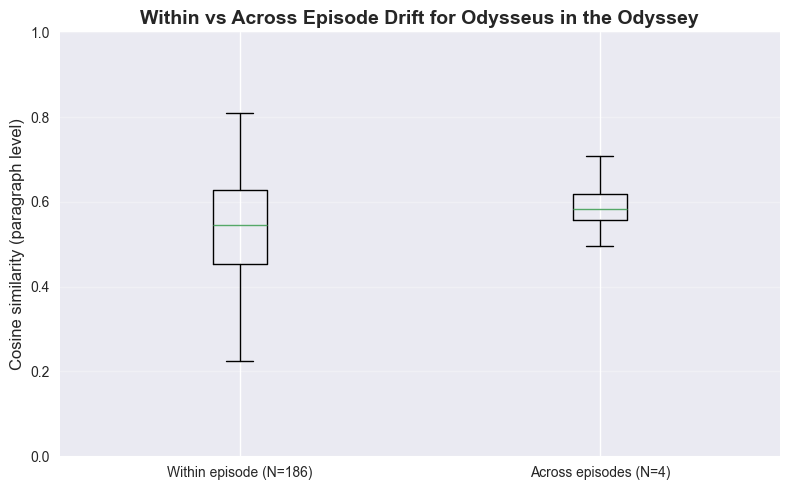

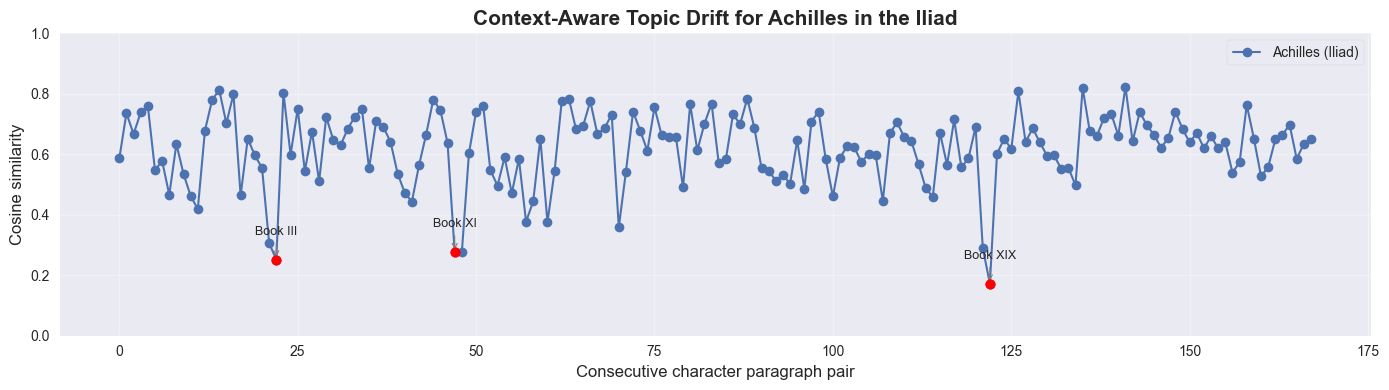

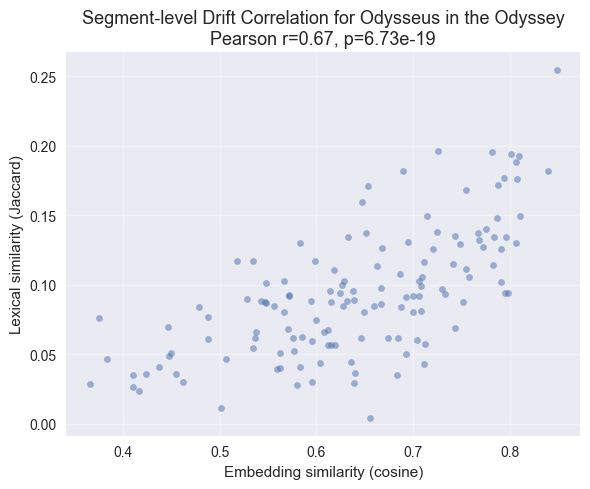

In [79]:
# 1. Odysseus drift: Iliad vs Odyssey (main result + robustness)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# Main model (all-MiniLM-L6-v2)
ody_iliad_main = char_drift_iliad.get("odysseus")
ody_odys_main = char_drift_odyssey.get("odysseus")

if ody_iliad_main is not None and ody_odys_main is not None:
    means_main = [float(ody_iliad_main.mean()), float(ody_odys_main.mean())]
    stds_main = [float(ody_iliad_main.std()), float(ody_odys_main.std())]
    labels = ["Iliad", "Odyssey"]
    x = np.arange(len(labels))

    axes[0].bar(x, means_main, yerr=stds_main, capsize=6,
                color=["#1f77b4", "#ff7f0e"], alpha=0.8)
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(labels)
    axes[0].set_ylim(0, 1)
    axes[0].set_ylabel("Mean cosine similarity", fontsize=11)
    axes[0].set_title("Main model (MiniLM-L6-v2)", fontsize=12)
    axes[0].grid(True, axis="y", alpha=0.3)
else:
    axes[0].text(0.5, 0.5, "Odysseus drift (main) not available",
                 ha="center", va="center", fontsize=11)
    axes[0].set_axis_off()

# Alternate model (all-MiniLM-L12-v2) — robustness
if "sims_i_alt" in globals() and "sims_o_alt" in globals() and len(sims_i_alt) and len(sims_o_alt):
    means_alt = [float(sims_i_alt.mean()), float(sims_o_alt.mean())]
    stds_alt = [float(sims_i_alt.std()), float(sims_o_alt.std())]
    labels_alt = ["Iliad", "Odyssey"]
    x_alt = np.arange(len(labels_alt))

    axes[1].bar(x_alt, means_alt, yerr=stds_alt, capsize=6,
                color=["#1f77b4", "#ff7f0e"], alpha=0.8)
    axes[1].set_xticks(x_alt)
    axes[1].set_xticklabels(labels_alt)
    axes[1].set_ylim(0, 1)
    axes[1].set_title("Alt model (MiniLM-L12-v2)", fontsize=12)
    axes[1].grid(True, axis="y", alpha=0.3)
else:
    axes[1].text(0.5, 0.5, "Alt-model drift not available\n(run robustness cell first)",
                 ha="center", va="center", fontsize=11)
    axes[1].set_axis_off()

fig.suptitle("Odysseus: Mean Local Topic Continuity in Iliad vs Odyssey", fontsize=14, fontweight="bold")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# 2. Achilles vs Hector drift in the Iliad (negative control)

achilles_iliad = char_drift_iliad.get("achilles")
hector_iliad = char_drift_iliad.get("hector")

if achilles_iliad is not None and hector_iliad is not None:
    data = [achilles_iliad, hector_iliad]
    labels = ["Achilles", "Hector"]

    plt.figure(figsize=(6, 4))
    plt.boxplot(data, labels=labels, showfliers=False)
    plt.ylim(0, 1)
    plt.ylabel("Cosine similarity (paragraph level)", fontsize=11)
    plt.title("Achilles vs Hector Local Topic Continuity (Iliad)", fontsize=13, fontweight="bold")
    plt.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Achilles/Hector drift not available.")


# 3. Within-episode vs across-episode drift for Odysseus in the Odyssey

plot_within_vs_across_episode("odysseus", epic="odyssey")


# 4. Character-level drift line with episode annotations (Achilles in the Iliad)

plot_character_drift_with_episodes("achilles", epic="iliad", top_n=3)


# 5. Embedding vs lexical similarity correlation for Odysseus segments (Odyssey)

plot_segment_drift_correlation("odysseus", epic="odyssey")


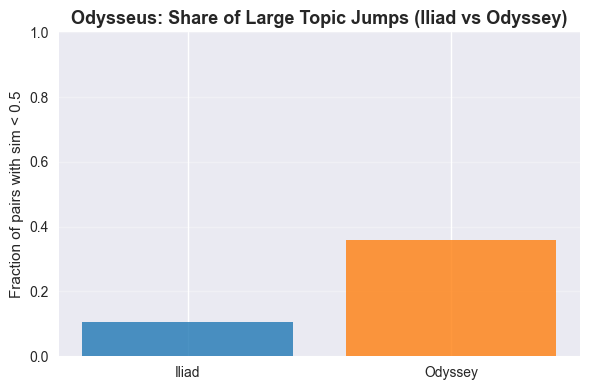

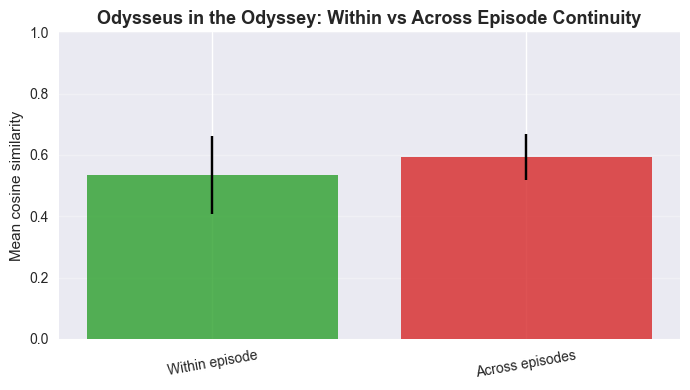

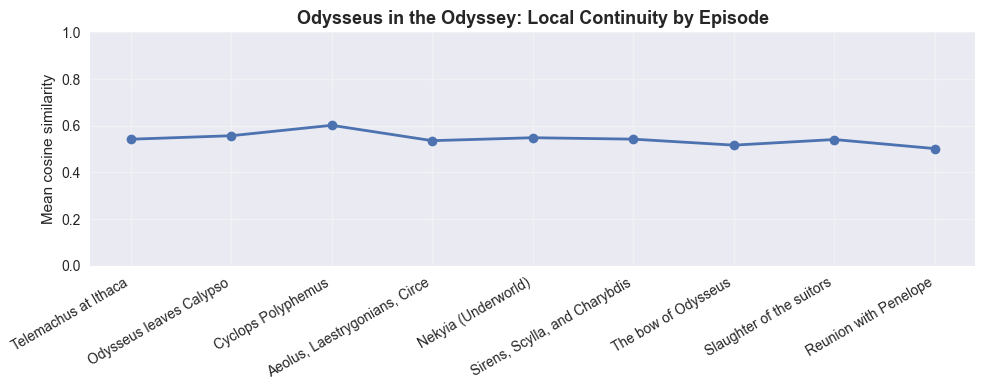

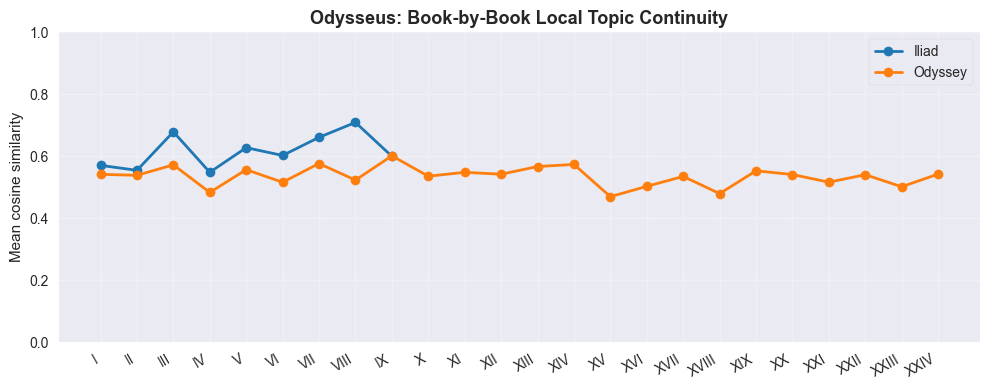

In [80]:
# Additional book- and episode-focused results

# Helper to compute within- vs across-episode similarities for a given character/epic

def get_within_across_episode_sims(char: str, epic: str = "odyssey"):
    if epic == "iliad":
        sims = char_drift_iliad.get(char)
        recs = char_pairs_iliad.get(char, [])
        meta = iliad_paragraphs_meta
    else:
        sims = char_drift_odyssey.get(char)
        recs = char_pairs_odyssey.get(char, [])
        meta = odyssey_paragraphs_meta

    within = []
    across = []
    if sims is None or len(sims) == 0:
        return np.array(within), np.array(across)

    for r in recs:
        i, j, sim = r["i"], r["j"], r["sim"]
        epi_i = meta[i].get("episode")
        epi_j = meta[j].get("episode")
        if epi_i and epi_j:
            if epi_i == epi_j:
                within.append(sim)
            else:
                across.append(sim)
    return np.array(within), np.array(across)


# 6. Bar plot: fraction of large topic jumps (low similarity) for Odysseus, Iliad vs Odyssey

THRESH = 0.5  # similarity threshold; below this counts as a "large jump"

ody_iliad = char_drift_iliad.get("odysseus")
ody_odys = char_drift_odyssey.get("odysseus")

if ody_iliad is not None and ody_odys is not None:
    frac_jump_iliad = float((ody_iliad < THRESH).mean())
    frac_jump_odys = float((ody_odys < THRESH).mean())

    labels = ["Iliad", "Odyssey"]
    fracs = [frac_jump_iliad, frac_jump_odys]

    plt.figure(figsize=(6, 4))
    plt.bar(labels, fracs, color=["#1f77b4", "#ff7f0e"], alpha=0.8)
    plt.ylim(0, 1)
    plt.ylabel(f"Fraction of pairs with sim < {THRESH}", fontsize=11)
    plt.title("Odysseus: Share of Large Topic Jumps (Iliad vs Odyssey)", fontsize=13, fontweight="bold")
    plt.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Odysseus drift not available for Iliad and/or Odyssey.")


# 7. Bar plot: Odysseus drift within vs across Odyssey episodes (means)

within_ody, across_ody = get_within_across_episode_sims("odysseus", epic="odyssey")

if len(within_ody) and len(across_ody):
    means = [float(within_ody.mean()), float(across_ody.mean())]
    stds = [float(within_ody.std()), float(across_ody.std())]
    labels = ["Within episode", "Across episodes"]
    x = np.arange(len(labels))

    plt.figure(figsize=(7, 4))
    plt.bar(x, means, yerr=stds, capsize=6, color=["#2ca02c", "#d62728"], alpha=0.8)
    plt.xticks(x, labels, rotation=10)
    plt.ylim(0, 1)
    plt.ylabel("Mean cosine similarity", fontsize=11)
    plt.title("Odysseus in the Odyssey: Within vs Across Episode Continuity", fontsize=13, fontweight="bold")
    plt.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Not enough within/across-episode pairs for Odysseus in the Odyssey.")


# 8. Episode-wise continuity for Odysseus in the Odyssey (labeled episodes only)

ody_pairs = char_pairs_odyssey.get("odysseus", [])

# collect similarities per episode label (for those paragraphs that fall into labeled episodes)
episode_sims: Dict[str, list[float]] = {}
for r in ody_pairs:
    i, j, sim = r["i"], r["j"], r["sim"]
    mid_idx = (i + j) // 2
    epi = odyssey_paragraphs_meta[mid_idx].get("episode")
    if epi:
        episode_sims.setdefault(epi, []).append(sim)

if episode_sims:
    episodes = list(episode_sims.keys())
    means_epi = [float(np.mean(episode_sims[e])) for e in episodes]

    plt.figure(figsize=(10, 4))
    plt.plot(range(len(episodes)), means_epi, marker="o", linewidth=2)
    plt.xticks(range(len(episodes)), episodes, rotation=30, ha="right")
    plt.ylim(0, 1)
    plt.ylabel("Mean cosine similarity", fontsize=11)
    plt.title("Odysseus in the Odyssey: Local Continuity by Episode", fontsize=13, fontweight="bold")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No labeled Odyssey episodes found in Odysseus drift records.")



# Book-by-book continuity for Odysseus in Iliad vs Odyssey

def compute_book_level_similarity(char: str, epic: str = "odyssey"):
    """
    For a given character and epic, compute mean similarity per book.

    Returns:
        books: list of book identifiers in narrative order
        means: list of mean similarities for each book
    """
    if epic == "iliad":
        pairs = char_pairs_iliad.get(char, [])
        meta = iliad_paragraphs_meta
    else:
        pairs = char_pairs_odyssey.get(char, [])
        meta = odyssey_paragraphs_meta

    sims_by_book = {}
    for r in pairs:
        i, j, sim = r["i"], r["j"], r["sim"]
        mid_idx = (i + j) // 2
        book = meta[mid_idx]["book"]
        if book is None:
            continue
        sims_by_book.setdefault(book, []).append(sim)

    # Sort books by first appearance (narrative order)
    books_in_order = sorted(
        sims_by_book.keys(),
        key=lambda b: next(
            m["global_idx"] for m in meta if m["book"] == b
        )
    )

    means = [float(np.mean(sims_by_book[b])) for b in books_in_order]
    return books_in_order, means

# Compute for Odysseus
books_iliad, means_iliad = compute_book_level_similarity("odysseus", epic="iliad")
books_odys, means_odys = compute_book_level_similarity("odysseus", epic="odyssey")

plt.figure(figsize=(10, 4))
plt.plot(range(len(books_iliad)), means_iliad, marker="o", linewidth=2, label="Iliad", color="#1f77b4")
plt.plot(range(len(books_odys)), means_odys, marker="o", linewidth=2, label="Odyssey", color="#ff7f0e")

plt.xticks(
    range(max(len(books_iliad), len(books_odys))),
    # Use Odyssey books if longer; adjust if you prefer
    (books_iliad if len(books_iliad) >= len(books_odys) else books_odys),
    rotation=30, ha="right"
)
plt.ylim(0, 1)
plt.ylabel("Mean cosine similarity", fontsize=11)
plt.title("Odysseus: Book-by-Book Local Topic Continuity", fontsize=13, fontweight="bold")
plt.grid(True, alpha=0.3)
plt.legend(frameon=True)
plt.tight_layout()
plt.show()


In [81]:
import gc

# Final cleanup cell — run *after* all analyses and summaries, if you need to free memory.
TO_DELETE = [
    "iliad_text", "odyssey_text", "combined_text",
    "paragraphs", "para_embeds", "paragraph_chars", "char_indices",
    "iliad_paragraphs_meta", "odyssey_paragraphs_meta",
    "iliad_paragraph_texts", "odyssey_paragraph_texts",
    "iliad_embeds", "odyssey_embeds",
    "iliad_para_chars", "odyssey_para_chars",
    "iliad_char_indices", "odyssey_char_indices",
    "char_drift_iliad", "char_drift_odyssey",
    "char_pairs_iliad", "char_pairs_odyssey",
    "iliad_segments_by_char", "odyssey_segments_by_char",
    "iliad_segment_embeds", "odyssey_segment_embeds",
    "iliad_segment_drift", "odyssey_segment_drift",
]

for name in TO_DELETE:
    if name in globals():
        del globals()[name]

# Clear matplotlib figures
plt.close('all')

# Unload models if present
for name in ["model"]:
    if name in globals():
        del globals()[name]

# Force garbage collection
gc.collect()

print("Final cleanup: large variables deleted where present and garbage collected.")


Final cleanup: large variables deleted where present and garbage collected.


### Key Findings and Limitations (Per-Character)

- **Achilles (Iliad)**: Local drift (paragraph and segment level) is **high but not uniquely extreme**; Hector shows comparable continuity, so we cannot claim greater "volatility" for Achilles from these metrics alone.
- **Odysseus (Iliad vs Odyssey)**: Odysseus in the *Odyssey* exhibits **lower average similarity** between nearby appearances than in the *Iliad*, consistent with his more varied, episodic journey, though still subject to translation and segmentation bias.
- **Athena and Zeus**: Gods show somewhat lower continuity than focused mortals and appear across many episodes, but regex-based detection and partial episode labeling limit how strongly we can link this to true "omnipresence" in the narrative.
- **Drift metrics**: Embedding-based and lexical drift correlate moderately, suggesting a real underlying signal, and speech↔narration transitions are frequent sites of large changes.

**Limitations (for any strong literary claim):**
- Character timelines rely on regex patterns plus a very simple pronoun heuristic; co-reference and ambiguous epithets remain sources of noise.
- Episode tags cover only major books, so within/across-episode results apply to a **subset** of transitions.
- All embeddings operate on Butler's English translation, blending Homeric structure with the translator's choices; conclusions are therefore about "Homer-as-Butler" rather than the Greek text itself.

These caveats should be kept in mind whenever moving from these quantitative patterns to fine-grained literary interpretation.
